In [140]:
import torch
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import torch.nn as nn
from torch.optim import Adam
import numpy as np
from tqdm import tqdm
from google.colab import drive
from torchvision.datasets import CIFAR10

In [141]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Data Loading

### Download and unzip the dataset

In [142]:
# !gdown https://drive.google.com/file/d/1y75TPaomSp2QlXeWWv-WMRbHVCKC5VB_/view?usp=sharing

In [143]:
# !unzip /content/CIFAR-10.zip;

### Loading and dividing the dataset into train, val and test sets

Initializing ImageFolder Instance

In [144]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((227,227))]) #resize images and load into tensor
# data_path = '/content'
dataset = CIFAR10(root='data/train/',download=True, train=True, transform=transform)
test_set = CIFAR10(root='data/test/',download=True, train=False, transform=transform)
#transform/load data, indexes and loads up the set of sub-dirs

Files already downloaded and verified
Files already downloaded and verified


Attributes of the dataset object

In [145]:
len(dataset) # number of samples

50000

In [146]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/train/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=warn)
           )

In [147]:
dataset.classes # classes(build in?????, figure this out later)

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [148]:
dataset.class_to_idx # indices of corresponding labels

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [149]:
dataset.transform

Compose(
    ToTensor()
    Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=warn)
)

In [150]:
class_counts = np.zeros(len(dataset.class_to_idx))

In [151]:
for image, label in dataset:
    class_counts[label] += 1

In [152]:
for i in range(len(class_counts)):
  print("class:%s, instances: %d"%([k for k,v in dataset.class_to_idx.items() if v == i], class_counts[i]))

class:['airplane'], instances: 5000
class:['automobile'], instances: 5000
class:['bird'], instances: 5000
class:['cat'], instances: 5000
class:['deer'], instances: 5000
class:['dog'], instances: 5000
class:['frog'], instances: 5000
class:['horse'], instances: 5000
class:['ship'], instances: 5000
class:['truck'], instances: 5000


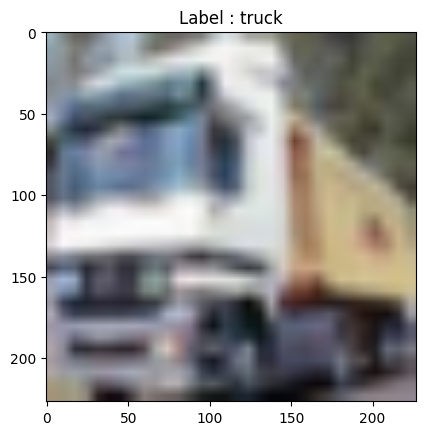

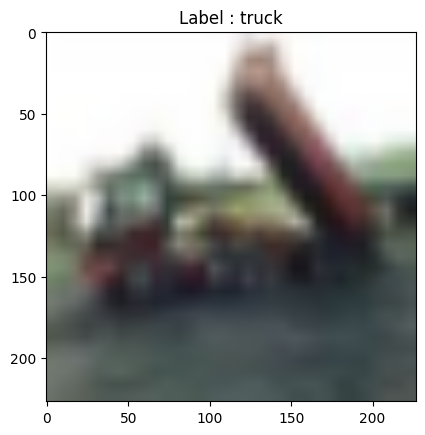

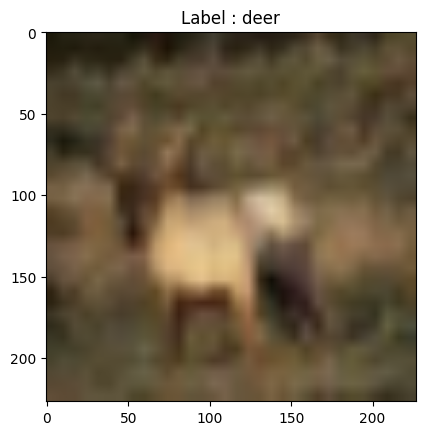

In [153]:
def display_img(img,label):
    #print(f"Label : {dataset.classes[label]}")
    plt.figure()
    plt.title(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
for i in range(1,4):
  display_img(*dataset[i])

Split into train, validation and test sets

In [154]:
# test train split, utils package, hard coded??? takes fractions??? check later,,,,, manual seed >> random seeding!!!
# train_set, val_set, test_set = torch.utils.data.random_split(dataset, [11924, 2555, 2555], generator=torch.Generator().manual_seed(42))

In [155]:
train_set = dataset
# print(train_set)

In [156]:
# train_set.indices

In [157]:
# train_set.dataset # dataset means train set is a part/subset of the dataset!,

Label : truck


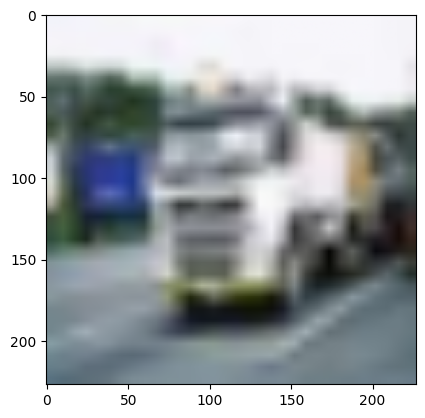

In [158]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*train_set[1000])

Initializing the pytorch dataloaders

In [159]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=16,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=16,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=16,
    shuffle=False
)


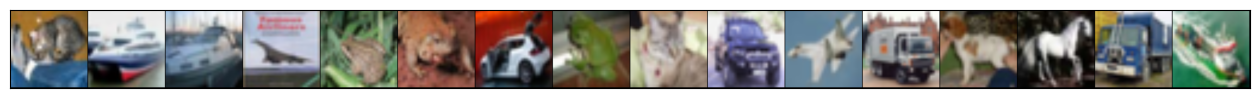

In [160]:
from torchvision.utils import make_grid

def show_batch(loader):
    """Plot images grid of single batch"""
    for images, labels in loader:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

show_batch(val_loader)

# Convolutional Neural Networks

## nn.Module method of constructing models

In [167]:
#TF>> sequential - simple
#  >> modular!! >> complex(flexible)



#Modular way!!!!
#torch.set_default_tensor_type('torch.cuda.FloatTensor')

class AlexNet(torch.nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__() #init parent class

        # Defining a 2D convolution layer
        self.conv1 = Conv2d(3, 96, kernel_size=11, stride=4, padding=0)#(input channels, output channels,------)
        self.bn1 = BatchNorm2d(96)
        self.relu1 = ReLU(inplace=True) ## note thr inplace, is it important????
        self.maxpool1 = MaxPool2d(kernel_size=3, stride=2)

        # Defining another 2D convolution layer
        self.conv2 = Conv2d(96, 256, kernel_size=5, padding=2)
        self.bn2 = BatchNorm2d(256)
        self.relu2 = ReLU(inplace=True)
        self.maxpool2 = MaxPool2d(kernel_size=3, stride=2)

        self.conv3 = Conv2d(256, 384, kernel_size=3, padding=1)
        self.bn3 = BatchNorm2d(384)
        self.relu3 = ReLU(inplace=True)
        # self.maxpool3 = MaxPool2d(kernel_size=3)

        self.conv4 = Conv2d(384, 384, kernel_size=3, padding=1)
        self.bn4 = BatchNorm2d(384)
        self.relu4 = ReLU(inplace=True)
        # self.maxpool4 = MaxPool2d(kernel_size=3)

        self.conv5 = Conv2d(384, 256, kernel_size=3, padding=1)
        self.bn5 = BatchNorm2d(256)
        self.relu5 = ReLU(inplace=True)
        self.maxpool3 = MaxPool2d(kernel_size=3, stride=2)

        #linear(input,output)
        self.linear_layers = Linear(256*6*6, 10)  ## flatten the image here. i.e linear layer!!
        # self.linear_layers = Linear(4096, 4096)  ## flatten the image here. i.e linear layer!!
        # self.linear_layers = Linear(9216, 10)  ## flatten the image here. i.e linear layer!!

    # Defining the forward pass
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # Apply conv2, bn2, relu2 and maxpool2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # Apply conv3, bn3, relu3 and maxpool3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        # x = self.maxpool3(x)

        # Apply conv4, bn4, relu4 and maxpool4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        # x = self.maxpool4(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.maxpool3(x)

        # Flatten the output from the conv layers
        x = torch.flatten(x,start_dim=1)

        # print(x.shape)

        # Apply the linear layer
        x = self.linear_layers(x)
        return x

In [168]:
# Initialize the model
model = AlexNet()
model.to(device)  # to GPU/CPU!!!!!!

AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU(inplace=True)
  (conv5): Conv2d(384, 256, kernel_s

## sequential method of constructing models

In [84]:
# sequential way

model = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(8),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(16),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            Linear(32 * 5 * 5, 6)
        )

# Visualization of Model

### Visualize through torchsummary

In [85]:
from torchsummary import summary

In [86]:
dummy_model = AlexNet().to(device)
summary(dummy_model, (3, 90, 90))  #-1 correspnds to batch size!, -1>> last or all remaining

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 20, 20]          34,944
       BatchNorm2d-2           [-1, 96, 20, 20]             192
              ReLU-3           [-1, 96, 20, 20]               0
         MaxPool2d-4             [-1, 96, 9, 9]               0
            Conv2d-5            [-1, 256, 9, 9]         614,656
       BatchNorm2d-6            [-1, 256, 9, 9]             512
              ReLU-7            [-1, 256, 9, 9]               0
         MaxPool2d-8            [-1, 256, 4, 4]               0
            Conv2d-9            [-1, 384, 4, 4]         885,120
      BatchNorm2d-10            [-1, 384, 4, 4]             768
             ReLU-11            [-1, 384, 4, 4]               0
           Conv2d-12            [-1, 384, 4, 4]       1,327,488
      BatchNorm2d-13            [-1, 384, 4, 4]             768
             ReLU-14            [-1, 38

### Visualize through TorchViz

In [87]:
!pip install torchviz

In [88]:
from torchviz import make_dot
dummy_image = next(iter(train_loader))[0]
dummy_model = AlexNet()
y_hat = dummy_model(dummy_image)

RuntimeError: ignored

In [ ]:
make_dot(y_hat.mean(),params=dict(dummy_model.named_parameters())).render("graph2", format="png")

In [ ]:
dummy_model.state_dict() # show the entire as dict!

### Model Configuration

In [169]:
# Select a loss function
loss_function = torch.nn.CrossEntropyLoss().to(device)

# Select an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

# Training Loop

Variable Initialization

In [170]:
len(train_loader) # number of images per batch

3125

In [171]:
def run_1_epoch(model, loss_fn, optimizer, loader, train = False):


  if train:
    model.train()
  else:
    model.eval()

  total_correct_preds = 0

  total_samples_in_loader = len(train_set)
  total_batches_in_loader = len(train_loader)

  total_loss = 0

  for image_batch, labels in tqdm(train_loader): #TPDM gives you proegress updates!

    # Transfer image_batch to GPU if available
    image_batch = image_batch.to(device) #gives you images of the batch
    labels = labels.to(device) #gives you labels of the batch

    # Zeroing out the gradients for parameters
    if train:
      optimizer.zero_grad() # pytorch doesnt reset gradients to zeros after each iteration and keeps adding to the previous,
      #if this is not done

    # Forward pass on the input batch
    output = model.forward(image_batch)

    # Acquire predicted class indices
    _, predicted = torch.max(output.data, 1) # the dimension 1 corresponds to max along the rows


    # Removing extra last dimension from output tensor
    output.squeeze_(-1)

    # Compute the loss for the minibatch
    loss = loss_function(output, labels)

    # Backpropagation
    if train:
      loss.backward()

    # Update the parameters using the gradients
    if train:
      optimizer.step()

    # Extra variables for calculating loss and accuracy
    # count total predictions for accuracy calcutuon for this epoch
    total_correct_preds += (predicted == labels).sum().item()

    total_loss += loss.item()

  loss = total_loss / total_batches_in_loader
  accuracy = 100 * total_correct_preds / total_samples_in_loader

  return loss, accuracy

In [172]:
epochs = 1

train_accuracy_list = []
val_accuracy_list = []

train_loss_list = []
val_loss_list = []

val_accuracy_max = -1 # used to store best model based on accuracy!

In [173]:
if torch.cuda.is_available():
    model.cuda()

In [174]:
# Main training and validation loop for n number of epochs
for i in range(epochs):

  # Train model for one epoch
  print("Epoch %d: Train"%(i))
  train_loss, train_accuracy  = run_1_epoch(model, loss_function, optimizer, train_loader, train= True)

  # Lists for train loss and accuracy for plotting
  train_loss_list.append(train_loss)
  train_accuracy_list.append(train_accuracy)

  # Validate the model on validation set
  print("Epoch %d: Validation"%(i))
  with torch.no_grad():
    val_loss, val_accuracy  = run_1_epoch(model, loss_function, optimizer, val_loader, train= False)

  # Lists for val loss and accuracy for plotting
  val_loss_list.append(val_loss)
  val_accuracy_list.append(val_accuracy)

  print('train loss: %.4f'%(train_loss))
  print('val loss: %.4f'%(val_loss))
  print('train_accuracy %.2f' % (train_accuracy))
  print('val_accuracy %.2f' % (val_accuracy))

  # Save model if validation accuracy for current epoch is greater than
  # all the previous epochs
  if val_accuracy > val_accuracy_max:
    val_accuracy_max = val_accuracy
    print("New Max val Accuracy Acheived %.2f. Saving model.\n\n"%(val_accuracy_max))
    torch.save(model,'best_val_acc_model.pth')
  else:
    print("val accuracy did not increase from %.2f\n\n"%(val_accuracy_max))


Epoch 0: Train


  0%|          | 2/3125 [00:00<03:29, 14.89it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  0%|          | 6/3125 [00:00<03:14, 16.05it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  0%|          | 10/3125 [00:00<03:20, 15.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  0%|          | 14/3125 [00:00<03:09, 16.38it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  1%|          | 18/3125 [00:01<03:11, 16.26it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  1%|          | 22/3125 [00:01<03:05, 16.73it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  1%|          | 26/3125 [00:01<03:35, 14.36it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  1%|          | 28/3125 [00:01<03:40, 14.03it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  1%|          | 32/3125 [00:02<03:48, 13.51it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  1%|          | 34/3125 [00:02<03:57, 13.04it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  1%|          | 38/3125 [00:02<03:57, 13.00it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  1%|▏         | 40/3125 [00:02<03:55, 13.09it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  1%|▏         | 44/3125 [00:03<03:53, 13.22it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  1%|▏         | 46/3125 [00:03<03:56, 13.03it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  2%|▏         | 50/3125 [00:03<03:55, 13.04it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  2%|▏         | 52/3125 [00:03<04:02, 12.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  2%|▏         | 56/3125 [00:04<04:00, 12.77it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  2%|▏         | 58/3125 [00:04<04:01, 12.72it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  2%|▏         | 62/3125 [00:04<03:32, 14.42it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  2%|▏         | 66/3125 [00:04<03:19, 15.35it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  2%|▏         | 72/3125 [00:05<03:07, 16.30it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  2%|▏         | 76/3125 [00:05<03:03, 16.59it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  3%|▎         | 80/3125 [00:05<03:00, 16.88it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  3%|▎         | 82/3125 [00:05<02:59, 16.95it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  3%|▎         | 88/3125 [00:05<02:59, 16.94it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  3%|▎         | 92/3125 [00:06<02:55, 17.25it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  3%|▎         | 96/3125 [00:06<02:56, 17.17it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  3%|▎         | 100/3125 [00:06<02:53, 17.44it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  3%|▎         | 104/3125 [00:06<02:55, 17.21it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  3%|▎         | 108/3125 [00:07<02:52, 17.53it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  4%|▎         | 112/3125 [00:07<02:50, 17.68it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  4%|▎         | 116/3125 [00:07<02:49, 17.77it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  4%|▍         | 120/3125 [00:07<02:55, 17.14it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  4%|▍         | 124/3125 [00:08<02:50, 17.56it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  4%|▍         | 128/3125 [00:08<02:51, 17.49it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  4%|▍         | 132/3125 [00:08<02:51, 17.47it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  4%|▍         | 136/3125 [00:08<02:50, 17.58it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  4%|▍         | 140/3125 [00:08<02:50, 17.46it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  5%|▍         | 144/3125 [00:09<02:49, 17.56it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  5%|▍         | 148/3125 [00:09<02:49, 17.55it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  5%|▍         | 152/3125 [00:09<02:47, 17.76it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  5%|▍         | 156/3125 [00:09<02:48, 17.65it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  5%|▌         | 160/3125 [00:10<02:48, 17.55it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  5%|▌         | 164/3125 [00:10<02:47, 17.63it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  5%|▌         | 168/3125 [00:10<02:49, 17.49it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  6%|▌         | 172/3125 [00:10<02:47, 17.61it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  6%|▌         | 176/3125 [00:10<02:47, 17.60it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  6%|▌         | 180/3125 [00:11<02:48, 17.46it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  6%|▌         | 184/3125 [00:11<02:51, 17.19it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  6%|▌         | 188/3125 [00:11<02:49, 17.33it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  6%|▌         | 192/3125 [00:11<02:48, 17.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  6%|▋         | 196/3125 [00:12<02:48, 17.41it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  6%|▋         | 200/3125 [00:12<02:50, 17.17it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  7%|▋         | 204/3125 [00:12<02:47, 17.42it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  7%|▋         | 208/3125 [00:12<02:50, 17.07it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  7%|▋         | 212/3125 [00:13<02:51, 16.98it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  7%|▋         | 216/3125 [00:13<02:51, 16.93it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  7%|▋         | 218/3125 [00:13<02:49, 17.20it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  7%|▋         | 224/3125 [00:13<02:50, 17.03it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  7%|▋         | 228/3125 [00:14<02:49, 17.06it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  7%|▋         | 230/3125 [00:14<02:52, 16.82it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  7%|▋         | 234/3125 [00:14<03:08, 15.34it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  8%|▊         | 238/3125 [00:14<03:25, 14.07it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  8%|▊         | 240/3125 [00:14<03:27, 13.90it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  8%|▊         | 242/3125 [00:15<04:06, 11.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


  8%|▊         | 244/3125 [00:15<05:25,  8.85it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


  8%|▊         | 246/3125 [00:15<05:44,  8.35it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


  8%|▊         | 249/3125 [00:16<07:26,  6.44it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


  8%|▊         | 251/3125 [00:16<07:20,  6.52it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


  8%|▊         | 252/3125 [00:16<07:16,  6.59it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


  8%|▊         | 255/3125 [00:17<07:24,  6.46it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  8%|▊         | 258/3125 [00:17<05:55,  8.07it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


  8%|▊         | 260/3125 [00:17<06:24,  7.45it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


  8%|▊         | 262/3125 [00:18<05:49,  8.18it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


  8%|▊         | 264/3125 [00:18<05:26,  8.76it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


  9%|▊         | 266/3125 [00:18<05:22,  8.88it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  9%|▊         | 269/3125 [00:18<04:59,  9.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


  9%|▊         | 271/3125 [00:18<04:47,  9.93it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])

  9%|▊         | 273/3125 [00:19<04:53,  9.72it/s]


torch.Size([16, 9216])


  9%|▉         | 274/3125 [00:19<04:57,  9.58it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  9%|▉         | 278/3125 [00:19<04:37, 10.25it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  9%|▉         | 280/3125 [00:19<04:39, 10.18it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


  9%|▉         | 284/3125 [00:20<04:32, 10.43it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  9%|▉         | 286/3125 [00:20<04:37, 10.24it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  9%|▉         | 290/3125 [00:20<04:24, 10.70it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  9%|▉         | 292/3125 [00:21<04:29, 10.50it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  9%|▉         | 295/3125 [00:21<05:09,  9.14it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 10%|▉         | 297/3125 [00:21<05:21,  8.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 10%|▉         | 299/3125 [00:21<05:34,  8.46it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 10%|▉         | 300/3125 [00:22<05:46,  8.15it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 10%|▉         | 303/3125 [00:22<05:31,  8.52it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 10%|▉         | 307/3125 [00:22<05:10,  9.09it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 10%|▉         | 308/3125 [00:22<05:09,  9.11it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 10%|▉         | 311/3125 [00:23<05:54,  7.94it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 10%|█         | 313/3125 [00:23<07:06,  6.59it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 10%|█         | 315/3125 [00:23<05:47,  8.08it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 10%|█         | 317/3125 [00:24<06:08,  7.62it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 10%|█         | 319/3125 [00:24<06:00,  7.78it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 10%|█         | 321/3125 [00:24<06:16,  7.44it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 10%|█         | 323/3125 [00:24<05:51,  7.96it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 10%|█         | 324/3125 [00:25<06:49,  6.84it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])

 10%|█         | 326/3125 [00:25<07:07,  6.54it/s]


torch.Size([16, 9216])


 10%|█         | 327/3125 [00:25<06:45,  6.91it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 11%|█         | 331/3125 [00:25<05:33,  8.39it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 11%|█         | 333/3125 [00:26<05:44,  8.11it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 11%|█         | 334/3125 [00:26<05:33,  8.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 11%|█         | 337/3125 [00:26<05:44,  8.09it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 11%|█         | 339/3125 [00:26<05:40,  8.17it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 11%|█         | 341/3125 [00:27<05:36,  8.28it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 11%|█         | 344/3125 [00:27<05:37,  8.23it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 11%|█         | 346/3125 [00:27<06:47,  6.82it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 11%|█         | 348/3125 [00:28<07:01,  6.59it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 11%|█         | 349/3125 [00:28<06:52,  6.73it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 11%|█         | 351/3125 [00:28<07:45,  5.96it/s]

torch.Size([16, 9216])


 11%|█▏        | 354/3125 [00:29<06:15,  7.38it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 11%|█▏        | 356/3125 [00:29<05:12,  8.85it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 12%|█▏        | 360/3125 [00:29<04:21, 10.59it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 12%|█▏        | 362/3125 [00:29<04:09, 11.07it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 12%|█▏        | 366/3125 [00:30<03:56, 11.65it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 12%|█▏        | 368/3125 [00:30<03:47, 12.14it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 12%|█▏        | 372/3125 [00:30<03:17, 13.96it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 12%|█▏        | 376/3125 [00:30<03:01, 15.10it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 12%|█▏        | 382/3125 [00:31<02:49, 16.14it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 12%|█▏        | 386/3125 [00:31<02:46, 16.46it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 12%|█▏        | 390/3125 [00:31<02:40, 17.01it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 13%|█▎        | 394/3125 [00:31<02:40, 17.00it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 13%|█▎        | 398/3125 [00:32<02:38, 17.24it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 13%|█▎        | 402/3125 [00:32<02:39, 17.05it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 13%|█▎        | 406/3125 [00:32<02:38, 17.21it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 13%|█▎        | 410/3125 [00:32<02:39, 16.97it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 13%|█▎        | 414/3125 [00:32<02:37, 17.25it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 13%|█▎        | 418/3125 [00:33<02:34, 17.50it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 13%|█▎        | 420/3125 [00:33<02:34, 17.53it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 14%|█▎        | 426/3125 [00:33<02:36, 17.27it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 14%|█▍        | 430/3125 [00:33<02:35, 17.36it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 14%|█▍        | 434/3125 [00:34<02:32, 17.70it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 14%|█▍        | 438/3125 [00:34<02:29, 17.92it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 14%|█▍        | 442/3125 [00:34<02:29, 17.90it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 14%|█▍        | 446/3125 [00:34<02:31, 17.70it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 14%|█▍        | 450/3125 [00:35<02:30, 17.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 15%|█▍        | 454/3125 [00:35<02:30, 17.73it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 15%|█▍        | 458/3125 [00:35<02:31, 17.60it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 15%|█▍        | 462/3125 [00:35<02:35, 17.14it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 15%|█▍        | 466/3125 [00:35<02:30, 17.67it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 15%|█▌        | 470/3125 [00:36<02:30, 17.68it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 15%|█▌        | 474/3125 [00:36<02:27, 17.91it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 15%|█▌        | 478/3125 [00:36<02:31, 17.52it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 15%|█▌        | 482/3125 [00:36<02:30, 17.56it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 16%|█▌        | 486/3125 [00:37<02:30, 17.57it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 16%|█▌        | 490/3125 [00:37<02:27, 17.81it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 16%|█▌        | 494/3125 [00:37<02:27, 17.81it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 16%|█▌        | 498/3125 [00:37<02:31, 17.38it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 16%|█▌        | 502/3125 [00:37<02:28, 17.66it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 16%|█▌        | 506/3125 [00:38<02:27, 17.70it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 16%|█▋        | 510/3125 [00:38<02:27, 17.67it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 16%|█▋        | 514/3125 [00:38<02:32, 17.17it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 17%|█▋        | 518/3125 [00:38<02:28, 17.53it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 17%|█▋        | 522/3125 [00:39<02:30, 17.29it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 17%|█▋        | 526/3125 [00:39<02:28, 17.53it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 17%|█▋        | 530/3125 [00:39<02:27, 17.56it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 17%|█▋        | 534/3125 [00:39<02:28, 17.44it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 17%|█▋        | 538/3125 [00:40<02:27, 17.55it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 17%|█▋        | 542/3125 [00:40<02:31, 17.04it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 17%|█▋        | 544/3125 [00:40<02:44, 15.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 18%|█▊        | 548/3125 [00:40<02:59, 14.34it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 18%|█▊        | 550/3125 [00:40<03:06, 13.84it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 18%|█▊        | 554/3125 [00:41<03:06, 13.75it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 18%|█▊        | 556/3125 [00:41<03:07, 13.71it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 18%|█▊        | 560/3125 [00:41<03:15, 13.14it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 18%|█▊        | 562/3125 [00:41<03:15, 13.08it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 18%|█▊        | 566/3125 [00:42<03:14, 13.15it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 18%|█▊        | 568/3125 [00:42<03:15, 13.08it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 18%|█▊        | 572/3125 [00:42<03:19, 12.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 18%|█▊        | 574/3125 [00:42<03:24, 12.48it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 18%|█▊        | 578/3125 [00:43<03:21, 12.62it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 19%|█▊        | 580/3125 [00:43<03:11, 13.31it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 19%|█▊        | 584/3125 [00:43<02:52, 14.70it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 19%|█▉        | 588/3125 [00:43<02:45, 15.34it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 19%|█▉        | 594/3125 [00:44<02:39, 15.91it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 19%|█▉        | 596/3125 [00:44<02:35, 16.27it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 19%|█▉        | 602/3125 [00:44<02:32, 16.56it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 19%|█▉        | 606/3125 [00:44<02:29, 16.84it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 19%|█▉        | 608/3125 [00:44<02:32, 16.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 20%|█▉        | 614/3125 [00:45<02:28, 16.87it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 20%|█▉        | 618/3125 [00:45<02:28, 16.86it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 20%|█▉        | 622/3125 [00:45<02:25, 17.16it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 20%|██        | 626/3125 [00:45<02:25, 17.15it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 20%|██        | 630/3125 [00:46<02:25, 17.17it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 20%|██        | 634/3125 [00:46<02:24, 17.24it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 20%|██        | 638/3125 [00:46<02:24, 17.15it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 21%|██        | 642/3125 [00:46<02:25, 17.10it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 21%|██        | 646/3125 [00:47<02:24, 17.20it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 21%|██        | 650/3125 [00:47<02:24, 17.13it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 21%|██        | 654/3125 [00:47<02:24, 17.11it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 21%|██        | 658/3125 [00:47<02:23, 17.17it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 21%|██        | 660/3125 [00:47<02:32, 16.18it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 21%|██        | 662/3125 [00:48<03:13, 12.74it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 21%|██        | 664/3125 [00:48<04:02, 10.14it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 21%|██▏       | 666/3125 [00:48<03:57, 10.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 21%|██▏       | 668/3125 [00:48<03:56, 10.40it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 21%|██▏       | 670/3125 [00:49<04:19,  9.47it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 22%|██▏       | 673/3125 [00:49<04:48,  8.50it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 22%|██▏       | 674/3125 [00:49<05:09,  7.92it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 22%|██▏       | 676/3125 [00:49<04:59,  8.18it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 22%|██▏       | 680/3125 [00:50<05:21,  7.61it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 22%|██▏       | 682/3125 [00:50<04:24,  9.23it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 22%|██▏       | 686/3125 [00:50<03:20, 12.19it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 22%|██▏       | 692/3125 [00:51<02:46, 14.63it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 22%|██▏       | 696/3125 [00:51<02:35, 15.58it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 22%|██▏       | 700/3125 [00:51<02:29, 16.24it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 23%|██▎       | 704/3125 [00:51<02:25, 16.64it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 23%|██▎       | 706/3125 [00:52<02:23, 16.83it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 23%|██▎       | 712/3125 [00:52<02:24, 16.70it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 23%|██▎       | 716/3125 [00:52<02:23, 16.74it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 23%|██▎       | 720/3125 [00:52<02:21, 16.96it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 23%|██▎       | 722/3125 [00:52<02:21, 16.92it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 23%|██▎       | 726/3125 [00:53<02:37, 15.24it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 23%|██▎       | 730/3125 [00:53<02:50, 14.02it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 23%|██▎       | 732/3125 [00:53<02:57, 13.46it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 24%|██▎       | 736/3125 [00:54<03:00, 13.20it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 24%|██▎       | 738/3125 [00:54<03:00, 13.21it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 24%|██▎       | 742/3125 [00:54<02:59, 13.25it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 24%|██▍       | 744/3125 [00:54<03:00, 13.17it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 24%|██▍       | 748/3125 [00:54<03:01, 13.10it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 24%|██▍       | 750/3125 [00:55<03:01, 13.09it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 24%|██▍       | 754/3125 [00:55<03:02, 12.98it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 24%|██▍       | 756/3125 [00:55<03:04, 12.85it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 24%|██▍       | 760/3125 [00:55<03:03, 12.86it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 24%|██▍       | 762/3125 [00:56<02:56, 13.36it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 25%|██▍       | 766/3125 [00:56<02:49, 13.95it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 25%|██▍       | 772/3125 [00:56<02:31, 15.50it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 25%|██▍       | 776/3125 [00:56<02:26, 16.09it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 25%|██▍       | 780/3125 [00:57<02:19, 16.81it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 25%|██▌       | 784/3125 [00:57<02:16, 17.21it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 25%|██▌       | 788/3125 [00:57<02:13, 17.51it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 25%|██▌       | 792/3125 [00:57<02:13, 17.50it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 25%|██▌       | 796/3125 [00:58<02:11, 17.64it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 26%|██▌       | 800/3125 [00:58<02:11, 17.62it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 26%|██▌       | 804/3125 [00:58<02:13, 17.38it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 26%|██▌       | 808/3125 [00:58<02:11, 17.62it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 26%|██▌       | 812/3125 [00:58<02:13, 17.35it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 26%|██▌       | 816/3125 [00:59<02:11, 17.51it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 26%|██▌       | 820/3125 [00:59<02:13, 17.31it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 26%|██▋       | 824/3125 [00:59<02:11, 17.52it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 26%|██▋       | 828/3125 [00:59<02:12, 17.29it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 27%|██▋       | 832/3125 [01:00<02:11, 17.43it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 27%|██▋       | 836/3125 [01:00<02:12, 17.28it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 27%|██▋       | 840/3125 [01:00<02:11, 17.42it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 27%|██▋       | 844/3125 [01:00<02:09, 17.55it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 27%|██▋       | 848/3125 [01:01<02:08, 17.76it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 27%|██▋       | 852/3125 [01:01<02:08, 17.68it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 27%|██▋       | 856/3125 [01:01<02:10, 17.38it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 28%|██▊       | 860/3125 [01:01<02:09, 17.43it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 28%|██▊       | 864/3125 [01:01<02:08, 17.56it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 28%|██▊       | 868/3125 [01:02<02:08, 17.55it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 28%|██▊       | 872/3125 [01:02<02:09, 17.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 28%|██▊       | 876/3125 [01:02<02:08, 17.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 28%|██▊       | 880/3125 [01:02<02:10, 17.27it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 28%|██▊       | 884/3125 [01:03<02:09, 17.28it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 28%|██▊       | 888/3125 [01:03<02:08, 17.40it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 28%|██▊       | 890/3125 [01:03<02:17, 16.24it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 29%|██▊       | 896/3125 [01:03<02:12, 16.82it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 29%|██▊       | 898/3125 [01:03<02:11, 16.94it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 29%|██▉       | 904/3125 [01:04<02:12, 16.76it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 29%|██▉       | 908/3125 [01:04<02:13, 16.66it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 29%|██▉       | 912/3125 [01:04<02:11, 16.78it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 29%|██▉       | 916/3125 [01:05<02:09, 17.12it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 29%|██▉       | 920/3125 [01:05<02:07, 17.30it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 30%|██▉       | 922/3125 [01:05<02:13, 16.51it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 30%|██▉       | 928/3125 [01:05<02:08, 17.10it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 30%|██▉       | 932/3125 [01:05<02:06, 17.28it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 30%|██▉       | 934/3125 [01:06<02:17, 15.95it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 30%|███       | 938/3125 [01:06<02:31, 14.39it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 30%|███       | 940/3125 [01:06<02:41, 13.55it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 30%|███       | 944/3125 [01:06<02:39, 13.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 30%|███       | 946/3125 [01:07<02:39, 13.65it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 30%|███       | 950/3125 [01:07<02:37, 13.77it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 30%|███       | 952/3125 [01:07<02:40, 13.52it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 31%|███       | 956/3125 [01:07<02:52, 12.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 31%|███       | 958/3125 [01:07<02:50, 12.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 31%|███       | 962/3125 [01:08<02:48, 12.81it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 31%|███       | 964/3125 [01:08<02:48, 12.84it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 31%|███       | 968/3125 [01:08<02:55, 12.31it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 31%|███       | 970/3125 [01:08<02:42, 13.25it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 31%|███       | 974/3125 [01:09<02:28, 14.48it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 31%|███▏      | 978/3125 [01:09<02:21, 15.17it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 31%|███▏      | 982/3125 [01:09<02:17, 15.57it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 32%|███▏      | 988/3125 [01:09<02:10, 16.32it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 32%|███▏      | 992/3125 [01:10<02:09, 16.50it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 32%|███▏      | 996/3125 [01:10<02:07, 16.72it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 32%|███▏      | 1000/3125 [01:10<02:08, 16.51it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 32%|███▏      | 1004/3125 [01:10<02:06, 16.72it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 32%|███▏      | 1008/3125 [01:11<02:04, 16.97it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 32%|███▏      | 1012/3125 [01:11<02:02, 17.19it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 33%|███▎      | 1016/3125 [01:11<02:01, 17.43it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 33%|███▎      | 1020/3125 [01:11<01:58, 17.83it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 33%|███▎      | 1024/3125 [01:12<01:59, 17.65it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 33%|███▎      | 1028/3125 [01:12<01:59, 17.53it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 33%|███▎      | 1032/3125 [01:12<02:02, 17.11it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 33%|███▎      | 1036/3125 [01:12<02:02, 17.03it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 33%|███▎      | 1040/3125 [01:13<01:59, 17.44it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 33%|███▎      | 1044/3125 [01:13<01:58, 17.61it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 34%|███▎      | 1048/3125 [01:13<01:59, 17.44it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 34%|███▎      | 1052/3125 [01:13<02:01, 17.12it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 34%|███▍      | 1056/3125 [01:13<01:58, 17.42it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 34%|███▍      | 1060/3125 [01:14<01:55, 17.81it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 34%|███▍      | 1064/3125 [01:14<01:55, 17.90it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 34%|███▍      | 1068/3125 [01:14<01:57, 17.57it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 34%|███▍      | 1072/3125 [01:14<01:58, 17.30it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 34%|███▍      | 1076/3125 [01:15<01:56, 17.57it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 35%|███▍      | 1080/3125 [01:15<01:54, 17.82it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 35%|███▍      | 1084/3125 [01:15<01:55, 17.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 35%|███▍      | 1088/3125 [01:15<01:58, 17.20it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 35%|███▍      | 1092/3125 [01:15<01:57, 17.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 35%|███▌      | 1096/3125 [01:16<01:54, 17.67it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 35%|███▌      | 1100/3125 [01:16<01:54, 17.68it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 35%|███▌      | 1104/3125 [01:16<01:52, 17.90it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 35%|███▌      | 1108/3125 [01:16<01:53, 17.79it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 36%|███▌      | 1112/3125 [01:17<01:54, 17.56it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 36%|███▌      | 1116/3125 [01:17<01:53, 17.67it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 36%|███▌      | 1120/3125 [01:17<01:53, 17.73it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 36%|███▌      | 1124/3125 [01:17<01:55, 17.33it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 36%|███▌      | 1128/3125 [01:18<01:53, 17.53it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 36%|███▌      | 1132/3125 [01:18<01:53, 17.56it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 36%|███▋      | 1136/3125 [01:18<01:54, 17.41it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 36%|███▋      | 1140/3125 [01:18<01:54, 17.40it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 37%|███▋      | 1142/3125 [01:18<02:02, 16.17it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 37%|███▋      | 1146/3125 [01:19<02:14, 14.72it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 37%|███▋      | 1148/3125 [01:19<02:23, 13.73it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 37%|███▋      | 1152/3125 [01:19<02:26, 13.44it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 37%|███▋      | 1154/3125 [01:19<02:28, 13.31it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 37%|███▋      | 1158/3125 [01:20<02:35, 12.67it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 37%|███▋      | 1160/3125 [01:20<02:34, 12.71it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 37%|███▋      | 1164/3125 [01:20<02:30, 13.03it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 37%|███▋      | 1166/3125 [01:20<02:30, 12.99it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 37%|███▋      | 1170/3125 [01:21<02:33, 12.71it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 38%|███▊      | 1172/3125 [01:21<02:34, 12.65it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 38%|███▊      | 1176/3125 [01:21<02:33, 12.72it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 38%|███▊      | 1178/3125 [01:21<02:28, 13.15it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 38%|███▊      | 1182/3125 [01:21<02:16, 14.21it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 38%|███▊      | 1188/3125 [01:22<02:04, 15.56it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 38%|███▊      | 1192/3125 [01:22<02:02, 15.84it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 38%|███▊      | 1196/3125 [01:22<01:59, 16.12it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 38%|███▊      | 1200/3125 [01:23<01:57, 16.35it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 39%|███▊      | 1204/3125 [01:23<01:56, 16.52it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 39%|███▊      | 1208/3125 [01:23<01:56, 16.52it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 39%|███▉      | 1212/3125 [01:23<01:53, 16.83it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 39%|███▉      | 1216/3125 [01:23<01:54, 16.65it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 39%|███▉      | 1220/3125 [01:24<01:54, 16.67it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 39%|███▉      | 1224/3125 [01:24<01:52, 16.84it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 39%|███▉      | 1228/3125 [01:24<01:53, 16.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 39%|███▉      | 1232/3125 [01:24<01:51, 17.00it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 40%|███▉      | 1236/3125 [01:25<01:53, 16.57it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 40%|███▉      | 1240/3125 [01:25<01:52, 16.71it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 40%|███▉      | 1244/3125 [01:25<01:50, 16.97it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 40%|███▉      | 1248/3125 [01:25<01:51, 16.86it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 40%|████      | 1252/3125 [01:26<01:51, 16.84it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 40%|████      | 1254/3125 [01:26<01:53, 16.42it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 40%|████      | 1260/3125 [01:26<01:49, 17.01it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 40%|████      | 1264/3125 [01:26<01:47, 17.27it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 41%|████      | 1268/3125 [01:27<01:48, 17.06it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 41%|████      | 1272/3125 [01:27<01:46, 17.42it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 41%|████      | 1276/3125 [01:27<01:47, 17.21it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 41%|████      | 1280/3125 [01:27<01:46, 17.27it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 41%|████      | 1284/3125 [01:27<01:45, 17.51it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 41%|████      | 1288/3125 [01:28<01:46, 17.31it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 41%|████▏     | 1292/3125 [01:28<01:45, 17.31it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 41%|████▏     | 1296/3125 [01:28<01:45, 17.38it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 42%|████▏     | 1300/3125 [01:28<01:47, 17.04it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 42%|████▏     | 1304/3125 [01:29<01:46, 17.13it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 42%|████▏     | 1308/3125 [01:29<01:45, 17.18it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 42%|████▏     | 1312/3125 [01:29<01:44, 17.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 42%|████▏     | 1316/3125 [01:29<01:44, 17.32it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 42%|████▏     | 1320/3125 [01:30<01:46, 16.99it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 42%|████▏     | 1324/3125 [01:30<01:45, 17.04it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 42%|████▏     | 1328/3125 [01:30<01:46, 16.85it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 43%|████▎     | 1332/3125 [01:30<01:46, 16.82it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 43%|████▎     | 1336/3125 [01:31<01:45, 17.01it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 43%|████▎     | 1340/3125 [01:31<01:44, 17.03it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 43%|████▎     | 1344/3125 [01:31<01:44, 17.00it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 43%|████▎     | 1346/3125 [01:31<01:48, 16.45it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 43%|████▎     | 1350/3125 [01:31<02:00, 14.77it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 43%|████▎     | 1352/3125 [01:32<02:05, 14.07it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 43%|████▎     | 1356/3125 [01:32<02:09, 13.61it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 43%|████▎     | 1358/3125 [01:32<02:11, 13.48it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 44%|████▎     | 1362/3125 [01:32<02:13, 13.25it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 44%|████▎     | 1364/3125 [01:33<02:14, 13.12it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 44%|████▍     | 1368/3125 [01:33<02:16, 12.91it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 44%|████▍     | 1370/3125 [01:33<02:17, 12.79it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 44%|████▍     | 1374/3125 [01:33<02:19, 12.56it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 44%|████▍     | 1376/3125 [01:33<02:17, 12.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 44%|████▍     | 1380/3125 [01:34<02:20, 12.40it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 44%|████▍     | 1382/3125 [01:34<02:19, 12.52it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 44%|████▍     | 1386/3125 [01:34<02:08, 13.58it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 44%|████▍     | 1390/3125 [01:34<01:59, 14.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 45%|████▍     | 1394/3125 [01:35<01:54, 15.15it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 45%|████▍     | 1398/3125 [01:35<01:50, 15.62it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 45%|████▍     | 1402/3125 [01:35<01:49, 15.68it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 45%|████▍     | 1406/3125 [01:36<01:47, 15.92it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 45%|████▌     | 1410/3125 [01:36<01:50, 15.57it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 45%|████▌     | 1414/3125 [01:36<01:48, 15.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 45%|████▌     | 1418/3125 [01:36<01:44, 16.31it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 46%|████▌     | 1422/3125 [01:36<01:41, 16.73it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 46%|████▌     | 1426/3125 [01:37<01:39, 17.02it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 46%|████▌     | 1428/3125 [01:37<01:42, 16.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 46%|████▌     | 1434/3125 [01:37<01:42, 16.56it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 46%|████▌     | 1438/3125 [01:37<01:40, 16.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 46%|████▌     | 1442/3125 [01:38<01:38, 17.00it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 46%|████▌     | 1444/3125 [01:38<01:38, 17.08it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 46%|████▋     | 1450/3125 [01:38<01:40, 16.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 47%|████▋     | 1454/3125 [01:38<01:39, 16.86it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 47%|████▋     | 1458/3125 [01:39<01:38, 17.00it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 47%|████▋     | 1462/3125 [01:39<01:35, 17.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 47%|████▋     | 1466/3125 [01:39<01:37, 17.02it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 47%|████▋     | 1470/3125 [01:39<01:36, 17.22it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 47%|████▋     | 1474/3125 [01:40<01:34, 17.39it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 47%|████▋     | 1478/3125 [01:40<01:34, 17.49it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 47%|████▋     | 1482/3125 [01:40<01:38, 16.76it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 48%|████▊     | 1486/3125 [01:40<01:36, 16.92it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 48%|████▊     | 1490/3125 [01:41<01:34, 17.24it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 48%|████▊     | 1494/3125 [01:41<01:38, 16.62it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 48%|████▊     | 1498/3125 [01:41<01:34, 17.14it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 48%|████▊     | 1502/3125 [01:41<01:33, 17.41it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 48%|████▊     | 1506/3125 [01:41<01:31, 17.63it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 48%|████▊     | 1510/3125 [01:42<01:32, 17.49it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 48%|████▊     | 1514/3125 [01:42<01:31, 17.61it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 49%|████▊     | 1516/3125 [01:42<01:31, 17.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 49%|████▊     | 1522/3125 [01:42<01:35, 16.87it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 49%|████▉     | 1526/3125 [01:43<01:33, 17.05it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 49%|████▉     | 1530/3125 [01:43<01:31, 17.43it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 49%|████▉     | 1534/3125 [01:43<01:33, 16.97it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 49%|████▉     | 1538/3125 [01:43<01:32, 17.08it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 49%|████▉     | 1542/3125 [01:44<01:32, 17.13it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 49%|████▉     | 1546/3125 [01:44<01:31, 17.24it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 50%|████▉     | 1550/3125 [01:44<01:33, 16.89it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 50%|████▉     | 1552/3125 [01:44<01:36, 16.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 50%|████▉     | 1556/3125 [01:44<01:49, 14.31it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 50%|████▉     | 1558/3125 [01:45<01:53, 13.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 50%|████▉     | 1562/3125 [01:45<01:56, 13.41it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 50%|█████     | 1564/3125 [01:45<01:57, 13.26it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 50%|█████     | 1568/3125 [01:45<02:00, 12.96it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 50%|█████     | 1570/3125 [01:46<02:00, 12.89it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 50%|█████     | 1574/3125 [01:46<02:00, 12.90it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 50%|█████     | 1576/3125 [01:46<02:01, 12.76it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 51%|█████     | 1580/3125 [01:46<02:00, 12.82it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 51%|█████     | 1582/3125 [01:46<02:02, 12.64it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 51%|█████     | 1586/3125 [01:47<02:05, 12.30it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 51%|█████     | 1588/3125 [01:47<02:04, 12.35it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 51%|█████     | 1592/3125 [01:47<01:54, 13.35it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 51%|█████     | 1596/3125 [01:48<01:45, 14.44it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 51%|█████     | 1600/3125 [01:48<01:42, 14.87it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 51%|█████▏    | 1604/3125 [01:48<01:40, 15.08it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 51%|█████▏    | 1608/3125 [01:48<01:40, 15.11it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 52%|█████▏    | 1612/3125 [01:49<01:37, 15.49it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 52%|█████▏    | 1616/3125 [01:49<01:36, 15.56it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 52%|█████▏    | 1620/3125 [01:49<01:34, 15.91it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 52%|█████▏    | 1624/3125 [01:49<01:35, 15.77it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 52%|█████▏    | 1628/3125 [01:50<01:33, 15.93it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 52%|█████▏    | 1632/3125 [01:50<01:34, 15.83it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 52%|█████▏    | 1636/3125 [01:50<01:33, 15.92it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 52%|█████▏    | 1640/3125 [01:50<01:33, 15.82it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 53%|█████▎    | 1644/3125 [01:51<01:34, 15.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 53%|█████▎    | 1648/3125 [01:51<01:32, 16.05it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 53%|█████▎    | 1652/3125 [01:51<01:32, 15.96it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 53%|█████▎    | 1656/3125 [01:51<01:31, 16.05it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 53%|█████▎    | 1660/3125 [01:52<01:30, 16.13it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 53%|█████▎    | 1664/3125 [01:52<01:28, 16.45it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 53%|█████▎    | 1668/3125 [01:52<01:28, 16.52it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 54%|█████▎    | 1672/3125 [01:52<01:26, 16.72it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 54%|█████▎    | 1676/3125 [01:53<01:26, 16.79it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 54%|█████▍    | 1680/3125 [01:53<01:27, 16.55it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 54%|█████▍    | 1684/3125 [01:53<01:25, 16.82it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 54%|█████▍    | 1688/3125 [01:53<01:25, 16.90it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 54%|█████▍    | 1692/3125 [01:54<01:25, 16.85it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 54%|█████▍    | 1696/3125 [01:54<01:24, 16.82it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 54%|█████▍    | 1700/3125 [01:54<01:25, 16.72it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 55%|█████▍    | 1704/3125 [01:54<01:23, 16.97it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 55%|█████▍    | 1708/3125 [01:54<01:25, 16.62it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 55%|█████▍    | 1712/3125 [01:55<01:24, 16.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 55%|█████▍    | 1716/3125 [01:55<01:23, 16.87it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 55%|█████▌    | 1720/3125 [01:55<01:23, 16.86it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 55%|█████▌    | 1724/3125 [01:55<01:24, 16.65it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 55%|█████▌    | 1728/3125 [01:56<01:22, 16.83it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 55%|█████▌    | 1732/3125 [01:56<01:23, 16.72it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 56%|█████▌    | 1736/3125 [01:56<01:21, 16.96it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 56%|█████▌    | 1740/3125 [01:56<01:23, 16.64it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 56%|█████▌    | 1744/3125 [01:57<01:22, 16.68it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 56%|█████▌    | 1748/3125 [01:57<01:21, 16.82it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 56%|█████▌    | 1752/3125 [01:57<01:24, 16.22it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 56%|█████▌    | 1754/3125 [01:57<01:31, 14.92it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 56%|█████▋    | 1758/3125 [01:58<01:40, 13.56it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 56%|█████▋    | 1760/3125 [01:58<01:42, 13.26it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 56%|█████▋    | 1764/3125 [01:58<01:43, 13.11it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 57%|█████▋    | 1766/3125 [01:58<01:45, 12.86it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 57%|█████▋    | 1770/3125 [01:59<01:49, 12.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 57%|█████▋    | 1772/3125 [01:59<01:51, 12.08it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 57%|█████▋    | 1776/3125 [01:59<01:50, 12.17it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 57%|█████▋    | 1778/3125 [01:59<01:51, 12.07it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 57%|█████▋    | 1782/3125 [02:00<01:51, 12.07it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 57%|█████▋    | 1784/3125 [02:00<01:54, 11.70it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 57%|█████▋    | 1788/3125 [02:00<01:57, 11.42it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 57%|█████▋    | 1790/3125 [02:00<01:57, 11.35it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 57%|█████▋    | 1792/3125 [02:00<02:00, 11.06it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 57%|█████▋    | 1794/3125 [02:01<02:06, 10.55it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 58%|█████▊    | 1798/3125 [02:01<02:01, 10.89it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 58%|█████▊    | 1802/3125 [02:01<01:58, 11.20it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 58%|█████▊    | 1804/3125 [02:02<01:55, 11.44it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 58%|█████▊    | 1808/3125 [02:02<01:50, 11.96it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 58%|█████▊    | 1810/3125 [02:02<01:48, 12.16it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 58%|█████▊    | 1814/3125 [02:02<01:44, 12.50it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 58%|█████▊    | 1816/3125 [02:03<01:44, 12.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 58%|█████▊    | 1820/3125 [02:03<01:46, 12.29it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 58%|█████▊    | 1822/3125 [02:03<01:46, 12.29it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 58%|█████▊    | 1826/3125 [02:03<01:37, 13.28it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 59%|█████▊    | 1830/3125 [02:04<01:32, 14.06it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 59%|█████▊    | 1834/3125 [02:04<01:26, 14.87it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 59%|█████▉    | 1838/3125 [02:04<01:25, 15.04it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 59%|█████▉    | 1842/3125 [02:04<01:23, 15.28it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 59%|█████▉    | 1844/3125 [02:04<01:24, 15.20it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 59%|█████▉    | 1848/3125 [02:05<01:22, 15.40it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 59%|█████▉    | 1852/3125 [02:05<01:23, 15.27it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 59%|█████▉    | 1856/3125 [02:05<01:21, 15.50it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 60%|█████▉    | 1862/3125 [02:06<01:20, 15.77it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 60%|█████▉    | 1864/3125 [02:06<01:45, 11.98it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 60%|█████▉    | 1866/3125 [02:06<02:17,  9.17it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 60%|█████▉    | 1870/3125 [02:06<01:47, 11.67it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 60%|█████▉    | 1874/3125 [02:07<01:32, 13.49it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 60%|██████    | 1878/3125 [02:07<01:25, 14.59it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 60%|██████    | 1882/3125 [02:07<01:21, 15.26it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 60%|██████    | 1886/3125 [02:07<01:20, 15.43it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 60%|██████    | 1890/3125 [02:08<01:19, 15.61it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 61%|██████    | 1894/3125 [02:08<01:19, 15.42it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 61%|██████    | 1898/3125 [02:08<01:18, 15.65it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 61%|██████    | 1902/3125 [02:09<01:17, 15.73it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 61%|██████    | 1906/3125 [02:09<01:17, 15.65it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 61%|██████    | 1910/3125 [02:09<01:16, 15.78it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 61%|██████    | 1914/3125 [02:09<01:17, 15.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 61%|██████▏   | 1918/3125 [02:10<01:15, 16.00it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 62%|██████▏   | 1922/3125 [02:10<01:15, 16.03it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 62%|██████▏   | 1926/3125 [02:10<01:16, 15.61it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 62%|██████▏   | 1930/3125 [02:10<01:14, 15.93it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 62%|██████▏   | 1934/3125 [02:11<01:13, 16.12it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 62%|██████▏   | 1938/3125 [02:11<01:14, 16.01it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 62%|██████▏   | 1942/3125 [02:11<01:14, 15.97it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 62%|██████▏   | 1946/3125 [02:11<01:12, 16.33it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 62%|██████▏   | 1948/3125 [02:11<01:18, 14.90it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 62%|██████▏   | 1952/3125 [02:12<01:24, 13.82it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 63%|██████▎   | 1954/3125 [02:12<01:25, 13.65it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 63%|██████▎   | 1958/3125 [02:12<01:27, 13.30it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 63%|██████▎   | 1960/3125 [02:12<01:28, 13.17it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 63%|██████▎   | 1964/3125 [02:13<01:33, 12.47it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 63%|██████▎   | 1966/3125 [02:13<01:34, 12.31it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 63%|██████▎   | 1970/3125 [02:13<01:38, 11.78it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 63%|██████▎   | 1972/3125 [02:13<01:39, 11.61it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 63%|██████▎   | 1976/3125 [02:14<01:37, 11.73it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 63%|██████▎   | 1978/3125 [02:14<01:36, 11.86it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 63%|██████▎   | 1982/3125 [02:14<01:36, 11.88it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 63%|██████▎   | 1984/3125 [02:14<01:33, 12.19it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 64%|██████▎   | 1988/3125 [02:15<01:22, 13.70it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 64%|██████▎   | 1992/3125 [02:15<01:17, 14.66it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 64%|██████▍   | 1996/3125 [02:15<01:15, 14.99it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 64%|██████▍   | 2000/3125 [02:15<01:13, 15.31it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 64%|██████▍   | 2006/3125 [02:16<01:10, 15.93it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 64%|██████▍   | 2008/3125 [02:16<01:10, 15.86it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 64%|██████▍   | 2012/3125 [02:16<01:09, 15.96it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 65%|██████▍   | 2018/3125 [02:17<01:07, 16.38it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 65%|██████▍   | 2022/3125 [02:17<01:07, 16.36it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 65%|██████▍   | 2026/3125 [02:17<01:07, 16.21it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 65%|██████▍   | 2028/3125 [02:17<01:07, 16.24it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 65%|██████▌   | 2034/3125 [02:18<01:07, 16.27it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 65%|██████▌   | 2036/3125 [02:18<01:07, 16.21it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 65%|██████▌   | 2042/3125 [02:18<01:07, 16.16it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 65%|██████▌   | 2046/3125 [02:18<01:05, 16.40it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 66%|██████▌   | 2050/3125 [02:19<01:07, 15.98it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 66%|██████▌   | 2054/3125 [02:19<01:06, 16.11it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 66%|██████▌   | 2056/3125 [02:19<01:06, 15.98it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 66%|██████▌   | 2060/3125 [02:19<01:06, 15.92it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 66%|██████▌   | 2066/3125 [02:20<01:04, 16.34it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 66%|██████▌   | 2070/3125 [02:20<01:05, 16.00it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 66%|██████▋   | 2074/3125 [02:20<01:04, 16.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 66%|██████▋   | 2078/3125 [02:20<01:03, 16.39it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 67%|██████▋   | 2082/3125 [02:20<01:02, 16.57it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 67%|██████▋   | 2086/3125 [02:21<01:03, 16.36it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 67%|██████▋   | 2090/3125 [02:21<01:04, 16.03it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 67%|██████▋   | 2094/3125 [02:21<01:03, 16.20it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 67%|██████▋   | 2098/3125 [02:21<01:04, 16.03it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 67%|██████▋   | 2100/3125 [02:22<01:03, 16.05it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 67%|██████▋   | 2106/3125 [02:22<01:03, 16.02it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 68%|██████▊   | 2110/3125 [02:22<01:02, 16.29it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 68%|██████▊   | 2114/3125 [02:23<01:03, 15.87it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 68%|██████▊   | 2118/3125 [02:23<01:03, 15.97it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 68%|██████▊   | 2120/3125 [02:23<01:03, 15.88it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 68%|██████▊   | 2126/3125 [02:23<01:03, 15.79it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 68%|██████▊   | 2128/3125 [02:23<01:03, 15.76it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 68%|██████▊   | 2134/3125 [02:24<01:01, 16.12it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 68%|██████▊   | 2138/3125 [02:24<01:01, 16.05it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 68%|██████▊   | 2140/3125 [02:24<01:11, 13.86it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 69%|██████▊   | 2142/3125 [02:25<01:44,  9.39it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 69%|██████▊   | 2144/3125 [02:25<02:04,  7.89it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 69%|██████▊   | 2147/3125 [02:26<02:33,  6.35it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 69%|██████▊   | 2148/3125 [02:26<02:38,  6.18it/s]

torch.Size([16, 9216])


 69%|██████▉   | 2149/3125 [02:26<03:02,  5.35it/s]

torch.Size([16, 9216])


 69%|██████▉   | 2150/3125 [02:26<03:06,  5.22it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])

 69%|██████▉   | 2151/3125 [02:26<03:10,  5.11it/s]

 69%|██████▉   | 2152/3125 [02:27<03:28,  4.67it/s]

torch.Size([16, 9216])


 69%|██████▉   | 2153/3125 [02:27<03:50,  4.21it/s]

torch.Size([16, 9216])


 69%|██████▉   | 2155/3125 [02:27<03:27,  4.68it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 69%|██████▉   | 2157/3125 [02:28<02:50,  5.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 69%|██████▉   | 2158/3125 [02:28<03:06,  5.20it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])

 69%|██████▉   | 2159/3125 [02:28<03:11,  5.05it/s]


torch.Size([16, 9216])


 69%|██████▉   | 2162/3125 [02:28<02:43,  5.90it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 69%|██████▉   | 2164/3125 [02:29<02:30,  6.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 69%|██████▉   | 2165/3125 [02:29<02:49,  5.66it/s]

torch.Size([16, 9216])


 69%|██████▉   | 2167/3125 [02:29<02:45,  5.78it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 69%|██████▉   | 2169/3125 [02:29<01:57,  8.11it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 70%|██████▉   | 2173/3125 [02:30<01:23, 11.40it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 70%|██████▉   | 2177/3125 [02:30<01:12, 13.13it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 70%|██████▉   | 2181/3125 [02:30<01:07, 14.08it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 70%|██████▉   | 2185/3125 [02:31<01:02, 14.96it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 70%|███████   | 2189/3125 [02:31<01:02, 14.87it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 70%|███████   | 2193/3125 [02:31<01:00, 15.39it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 70%|███████   | 2197/3125 [02:31<00:58, 15.77it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 70%|███████   | 2201/3125 [02:32<00:58, 15.79it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 71%|███████   | 2205/3125 [02:32<00:58, 15.66it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 71%|███████   | 2211/3125 [02:32<00:56, 16.13it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 71%|███████   | 2215/3125 [02:32<00:56, 16.18it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 71%|███████   | 2219/3125 [02:33<00:54, 16.51it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 71%|███████   | 2221/3125 [02:33<00:55, 16.31it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 71%|███████▏  | 2227/3125 [02:33<00:55, 16.13it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 71%|███████▏  | 2229/3125 [02:33<00:55, 16.06it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 71%|███████▏  | 2233/3125 [02:34<00:56, 15.91it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 72%|███████▏  | 2239/3125 [02:34<00:55, 15.88it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 72%|███████▏  | 2241/3125 [02:34<00:55, 15.95it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 72%|███████▏  | 2247/3125 [02:34<00:53, 16.34it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 72%|███████▏  | 2249/3125 [02:35<00:53, 16.29it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 72%|███████▏  | 2255/3125 [02:35<00:53, 16.20it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 72%|███████▏  | 2259/3125 [02:35<00:53, 16.27it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 72%|███████▏  | 2263/3125 [02:35<00:52, 16.56it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 72%|███████▏  | 2265/3125 [02:36<00:52, 16.49it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 73%|███████▎  | 2271/3125 [02:36<00:52, 16.18it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 73%|███████▎  | 2275/3125 [02:36<00:52, 16.28it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 73%|███████▎  | 2279/3125 [02:36<00:51, 16.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 73%|███████▎  | 2283/3125 [02:37<00:50, 16.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 73%|███████▎  | 2285/3125 [02:37<00:50, 16.65it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 73%|███████▎  | 2291/3125 [02:37<00:50, 16.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 73%|███████▎  | 2295/3125 [02:37<00:49, 16.78it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 74%|███████▎  | 2299/3125 [02:38<00:49, 16.63it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 74%|███████▎  | 2303/3125 [02:38<00:50, 16.30it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 74%|███████▍  | 2307/3125 [02:38<00:49, 16.59it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 74%|███████▍  | 2309/3125 [02:38<00:50, 16.23it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 74%|███████▍  | 2313/3125 [02:39<00:57, 14.01it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 74%|███████▍  | 2315/3125 [02:39<00:58, 13.77it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 74%|███████▍  | 2319/3125 [02:39<01:00, 13.25it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 74%|███████▍  | 2321/3125 [02:39<01:00, 13.24it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 74%|███████▍  | 2325/3125 [02:39<01:00, 13.14it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 74%|███████▍  | 2327/3125 [02:40<01:02, 12.87it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 75%|███████▍  | 2331/3125 [02:40<01:04, 12.40it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 75%|███████▍  | 2333/3125 [02:40<01:05, 12.08it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 75%|███████▍  | 2337/3125 [02:40<01:04, 12.26it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 75%|███████▍  | 2339/3125 [02:41<01:03, 12.32it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 75%|███████▍  | 2343/3125 [02:41<01:03, 12.30it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 75%|███████▌  | 2345/3125 [02:41<01:03, 12.36it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 75%|███████▌  | 2349/3125 [02:41<01:00, 12.83it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 75%|███████▌  | 2351/3125 [02:42<00:57, 13.58it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 75%|███████▌  | 2355/3125 [02:42<00:53, 14.53it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 75%|███████▌  | 2359/3125 [02:42<00:51, 14.82it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 76%|███████▌  | 2363/3125 [02:42<00:51, 14.92it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 76%|███████▌  | 2367/3125 [02:43<00:49, 15.19it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 76%|███████▌  | 2371/3125 [02:43<00:48, 15.45it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 76%|███████▌  | 2375/3125 [02:43<00:49, 15.29it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 76%|███████▌  | 2379/3125 [02:43<00:48, 15.35it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 76%|███████▋  | 2383/3125 [02:44<00:47, 15.46it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 76%|███████▋  | 2387/3125 [02:44<00:47, 15.63it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 77%|███████▋  | 2391/3125 [02:44<00:48, 15.09it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 77%|███████▋  | 2395/3125 [02:44<00:47, 15.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 77%|███████▋  | 2399/3125 [02:45<00:47, 15.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 77%|███████▋  | 2403/3125 [02:45<00:46, 15.64it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 77%|███████▋  | 2407/3125 [02:45<00:46, 15.42it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 77%|███████▋  | 2413/3125 [02:46<00:45, 15.76it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 77%|███████▋  | 2415/3125 [02:46<00:44, 15.92it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 77%|███████▋  | 2421/3125 [02:46<00:43, 16.19it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 78%|███████▊  | 2423/3125 [02:46<00:44, 15.66it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 78%|███████▊  | 2429/3125 [02:47<00:42, 16.23it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 78%|███████▊  | 2433/3125 [02:47<00:42, 16.40it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 78%|███████▊  | 2437/3125 [02:47<00:41, 16.41it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 78%|███████▊  | 2439/3125 [02:47<00:43, 15.87it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 78%|███████▊  | 2445/3125 [02:48<00:42, 16.18it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 78%|███████▊  | 2447/3125 [02:48<00:42, 16.01it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 78%|███████▊  | 2451/3125 [02:48<00:43, 15.53it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 79%|███████▊  | 2455/3125 [02:48<00:43, 15.44it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 79%|███████▉  | 2461/3125 [02:49<00:41, 16.11it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 79%|███████▉  | 2465/3125 [02:49<00:40, 16.41it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 79%|███████▉  | 2467/3125 [02:49<00:40, 16.27it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 79%|███████▉  | 2471/3125 [02:49<00:42, 15.46it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 79%|███████▉  | 2475/3125 [02:49<00:41, 15.84it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 79%|███████▉  | 2479/3125 [02:50<00:40, 16.07it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 79%|███████▉  | 2483/3125 [02:50<00:42, 15.13it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 80%|███████▉  | 2487/3125 [02:50<00:42, 15.04it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 80%|███████▉  | 2491/3125 [02:50<00:40, 15.77it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 80%|███████▉  | 2495/3125 [02:51<00:39, 15.99it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 80%|███████▉  | 2499/3125 [02:51<00:40, 15.59it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 80%|████████  | 2503/3125 [02:51<00:39, 15.93it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 80%|████████  | 2507/3125 [02:52<00:43, 14.30it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 80%|████████  | 2509/3125 [02:52<00:44, 13.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 80%|████████  | 2513/3125 [02:52<00:46, 13.12it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 80%|████████  | 2515/3125 [02:52<00:47, 12.95it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 81%|████████  | 2519/3125 [02:53<00:47, 12.63it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 81%|████████  | 2521/3125 [02:53<00:48, 12.40it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 81%|████████  | 2525/3125 [02:53<00:48, 12.27it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 81%|████████  | 2527/3125 [02:53<00:48, 12.27it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 81%|████████  | 2531/3125 [02:54<00:49, 12.01it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 81%|████████  | 2533/3125 [02:54<00:50, 11.70it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 81%|████████  | 2537/3125 [02:54<00:49, 11.92it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 81%|████████  | 2539/3125 [02:54<00:49, 11.72it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 81%|████████▏ | 2543/3125 [02:55<00:49, 11.81it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 81%|████████▏ | 2545/3125 [02:55<00:46, 12.34it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 82%|████████▏ | 2549/3125 [02:55<00:42, 13.41it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 82%|████████▏ | 2553/3125 [02:55<00:40, 14.06it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 82%|████████▏ | 2557/3125 [02:55<00:40, 14.18it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 82%|████████▏ | 2561/3125 [02:56<00:38, 14.59it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 82%|████████▏ | 2565/3125 [02:56<00:38, 14.38it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 82%|████████▏ | 2569/3125 [02:56<00:37, 14.65it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 82%|████████▏ | 2573/3125 [02:57<00:38, 14.49it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 82%|████████▏ | 2577/3125 [02:57<00:37, 14.65it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 83%|████████▎ | 2581/3125 [02:57<00:36, 14.82it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 83%|████████▎ | 2585/3125 [02:57<00:36, 14.88it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 83%|████████▎ | 2589/3125 [02:58<00:35, 15.05it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 83%|████████▎ | 2593/3125 [02:58<00:34, 15.32it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 83%|████████▎ | 2597/3125 [02:58<00:34, 15.13it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 83%|████████▎ | 2601/3125 [02:58<00:35, 14.91it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 83%|████████▎ | 2605/3125 [02:59<00:34, 15.10it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 83%|████████▎ | 2609/3125 [02:59<00:33, 15.18it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 84%|████████▎ | 2613/3125 [02:59<00:33, 15.14it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 84%|████████▎ | 2617/3125 [02:59<00:33, 15.12it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 84%|████████▍ | 2621/3125 [03:00<00:33, 15.11it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 84%|████████▍ | 2625/3125 [03:00<00:33, 15.09it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 84%|████████▍ | 2629/3125 [03:00<00:32, 15.12it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 84%|████████▍ | 2633/3125 [03:01<00:32, 15.16it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 84%|████████▍ | 2637/3125 [03:01<00:33, 14.76it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 85%|████████▍ | 2641/3125 [03:01<00:32, 15.02it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 85%|████████▍ | 2645/3125 [03:01<00:31, 15.18it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 85%|████████▍ | 2649/3125 [03:02<00:31, 15.21it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 85%|████████▍ | 2653/3125 [03:02<00:31, 15.17it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 85%|████████▌ | 2657/3125 [03:02<00:31, 15.03it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 85%|████████▌ | 2661/3125 [03:02<00:30, 15.33it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 85%|████████▌ | 2665/3125 [03:03<00:29, 15.41it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 85%|████████▌ | 2669/3125 [03:03<00:29, 15.39it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 86%|████████▌ | 2673/3125 [03:03<00:29, 15.23it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 86%|████████▌ | 2677/3125 [03:03<00:30, 14.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 86%|████████▌ | 2681/3125 [03:04<00:29, 15.00it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 86%|████████▌ | 2685/3125 [03:04<00:28, 15.21it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 86%|████████▌ | 2689/3125 [03:04<00:28, 15.48it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 86%|████████▌ | 2693/3125 [03:04<00:28, 15.31it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 86%|████████▋ | 2697/3125 [03:05<00:31, 13.61it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 86%|████████▋ | 2699/3125 [03:05<00:32, 13.22it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 86%|████████▋ | 2703/3125 [03:05<00:32, 12.93it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 87%|████████▋ | 2705/3125 [03:05<00:34, 12.34it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 87%|████████▋ | 2709/3125 [03:06<00:33, 12.55it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 87%|████████▋ | 2711/3125 [03:06<00:32, 12.64it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 87%|████████▋ | 2715/3125 [03:06<00:32, 12.55it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 87%|████████▋ | 2717/3125 [03:06<00:33, 12.26it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 87%|████████▋ | 2721/3125 [03:07<00:33, 11.95it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 87%|████████▋ | 2723/3125 [03:07<00:33, 11.98it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 87%|████████▋ | 2727/3125 [03:07<00:33, 11.97it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 87%|████████▋ | 2729/3125 [03:07<00:33, 11.86it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 87%|████████▋ | 2733/3125 [03:08<00:30, 12.65it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 88%|████████▊ | 2735/3125 [03:08<00:28, 13.47it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 88%|████████▊ | 2739/3125 [03:08<00:27, 14.26it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 88%|████████▊ | 2743/3125 [03:08<00:25, 14.71it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 88%|████████▊ | 2747/3125 [03:09<00:25, 14.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 88%|████████▊ | 2751/3125 [03:09<00:25, 14.75it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 88%|████████▊ | 2755/3125 [03:09<00:24, 14.87it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 88%|████████▊ | 2759/3125 [03:09<00:24, 14.98it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 88%|████████▊ | 2763/3125 [03:10<00:24, 15.05it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 89%|████████▊ | 2767/3125 [03:10<00:24, 14.71it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 89%|████████▊ | 2771/3125 [03:10<00:23, 14.78it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 89%|████████▉ | 2775/3125 [03:11<00:23, 15.08it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 89%|████████▉ | 2779/3125 [03:11<00:22, 15.11it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 89%|████████▉ | 2783/3125 [03:11<00:23, 14.86it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 89%|████████▉ | 2785/3125 [03:11<00:23, 14.42it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 89%|████████▉ | 2789/3125 [03:11<00:22, 14.96it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 89%|████████▉ | 2793/3125 [03:12<00:22, 14.93it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 90%|████████▉ | 2797/3125 [03:12<00:22, 14.78it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 90%|████████▉ | 2801/3125 [03:12<00:22, 14.62it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 90%|████████▉ | 2805/3125 [03:13<00:21, 14.77it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 90%|████████▉ | 2809/3125 [03:13<00:22, 14.31it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 90%|█████████ | 2813/3125 [03:13<00:21, 14.46it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 90%|█████████ | 2817/3125 [03:13<00:21, 14.66it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 90%|█████████ | 2821/3125 [03:14<00:20, 14.78it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 90%|█████████ | 2825/3125 [03:14<00:19, 15.15it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 91%|█████████ | 2829/3125 [03:14<00:20, 14.51it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 91%|█████████ | 2833/3125 [03:14<00:19, 14.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 91%|█████████ | 2837/3125 [03:15<00:19, 14.76it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 91%|█████████ | 2841/3125 [03:15<00:18, 15.25it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 91%|█████████ | 2845/3125 [03:15<00:18, 14.87it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 91%|█████████ | 2849/3125 [03:16<00:18, 15.07it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 91%|█████████▏| 2853/3125 [03:16<00:18, 15.08it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 91%|█████████▏| 2857/3125 [03:16<00:17, 15.49it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 92%|█████████▏| 2861/3125 [03:16<00:17, 15.17it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 92%|█████████▏| 2865/3125 [03:17<00:16, 15.35it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 92%|█████████▏| 2869/3125 [03:17<00:16, 15.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 92%|█████████▏| 2873/3125 [03:17<00:16, 15.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 92%|█████████▏| 2877/3125 [03:17<00:16, 15.25it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 92%|█████████▏| 2881/3125 [03:18<00:15, 15.44it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 92%|█████████▏| 2883/3125 [03:18<00:16, 14.58it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 92%|█████████▏| 2887/3125 [03:18<00:18, 12.97it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 92%|█████████▏| 2889/3125 [03:18<00:19, 12.35it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 93%|█████████▎| 2893/3125 [03:19<00:18, 12.59it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 93%|█████████▎| 2895/3125 [03:19<00:18, 12.77it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 93%|█████████▎| 2899/3125 [03:19<00:17, 13.09it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 93%|█████████▎| 2901/3125 [03:19<00:17, 13.02it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 93%|█████████▎| 2905/3125 [03:20<00:17, 12.70it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 93%|█████████▎| 2907/3125 [03:20<00:17, 12.74it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 93%|█████████▎| 2911/3125 [03:20<00:16, 12.81it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 93%|█████████▎| 2913/3125 [03:20<00:16, 12.61it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 93%|█████████▎| 2917/3125 [03:21<00:16, 12.32it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 93%|█████████▎| 2919/3125 [03:21<00:16, 12.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 94%|█████████▎| 2923/3125 [03:21<00:16, 12.31it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 94%|█████████▎| 2925/3125 [03:21<00:15, 13.08it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 94%|█████████▎| 2929/3125 [03:21<00:14, 13.95it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 94%|█████████▍| 2933/3125 [03:22<00:13, 14.09it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 94%|█████████▍| 2937/3125 [03:22<00:12, 14.78it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 94%|█████████▍| 2939/3125 [03:22<00:12, 14.50it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 94%|█████████▍| 2943/3125 [03:22<00:12, 14.68it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 94%|█████████▍| 2947/3125 [03:23<00:11, 14.97it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 94%|█████████▍| 2951/3125 [03:23<00:11, 14.79it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 95%|█████████▍| 2955/3125 [03:23<00:11, 14.98it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 95%|█████████▍| 2959/3125 [03:23<00:11, 14.95it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 95%|█████████▍| 2963/3125 [03:24<00:10, 15.29it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 95%|█████████▍| 2967/3125 [03:24<00:10, 15.00it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 95%|█████████▌| 2969/3125 [03:24<00:10, 15.14it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 95%|█████████▌| 2973/3125 [03:24<00:10, 14.99it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 95%|█████████▌| 2977/3125 [03:25<00:09, 14.99it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 95%|█████████▌| 2981/3125 [03:25<00:09, 15.14it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 95%|█████████▌| 2983/3125 [03:25<00:09, 14.99it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 96%|█████████▌| 2987/3125 [03:25<00:09, 14.93it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 96%|█████████▌| 2991/3125 [03:26<00:08, 15.10it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 96%|█████████▌| 2995/3125 [03:26<00:08, 14.93it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 96%|█████████▌| 2999/3125 [03:26<00:08, 15.33it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 96%|█████████▌| 3003/3125 [03:26<00:07, 15.45it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 96%|█████████▌| 3007/3125 [03:27<00:07, 15.36it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 96%|█████████▋| 3011/3125 [03:27<00:07, 15.56it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 96%|█████████▋| 3015/3125 [03:27<00:07, 15.56it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 97%|█████████▋| 3019/3125 [03:27<00:06, 15.40it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 97%|█████████▋| 3023/3125 [03:28<00:06, 15.24it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 97%|█████████▋| 3029/3125 [03:28<00:06, 15.52it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 97%|█████████▋| 3033/3125 [03:28<00:05, 15.84it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 97%|█████████▋| 3035/3125 [03:28<00:05, 15.38it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 97%|█████████▋| 3041/3125 [03:29<00:05, 15.68it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 97%|█████████▋| 3045/3125 [03:29<00:05, 15.94it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 98%|█████████▊| 3049/3125 [03:29<00:04, 16.08it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 98%|█████████▊| 3053/3125 [03:30<00:04, 16.40it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 98%|█████████▊| 3057/3125 [03:30<00:04, 16.42it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 98%|█████████▊| 3061/3125 [03:30<00:03, 16.24it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 98%|█████████▊| 3063/3125 [03:30<00:03, 15.76it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 98%|█████████▊| 3069/3125 [03:31<00:03, 15.94it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 98%|█████████▊| 3071/3125 [03:31<00:03, 15.16it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 98%|█████████▊| 3075/3125 [03:31<00:03, 15.42it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 99%|█████████▊| 3079/3125 [03:31<00:03, 14.40it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 99%|█████████▊| 3083/3125 [03:32<00:03, 13.13it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 99%|█████████▊| 3085/3125 [03:32<00:03, 12.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 99%|█████████▉| 3089/3125 [03:32<00:02, 12.91it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 99%|█████████▉| 3091/3125 [03:32<00:02, 12.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 99%|█████████▉| 3095/3125 [03:32<00:02, 12.78it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 99%|█████████▉| 3097/3125 [03:33<00:02, 12.58it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 99%|█████████▉| 3101/3125 [03:33<00:01, 12.41it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 99%|█████████▉| 3103/3125 [03:33<00:01, 12.41it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 99%|█████████▉| 3107/3125 [03:33<00:01, 12.36it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 99%|█████████▉| 3109/3125 [03:34<00:01, 12.20it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


100%|█████████▉| 3113/3125 [03:34<00:00, 12.19it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


100%|█████████▉| 3115/3125 [03:34<00:00, 12.40it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


100%|█████████▉| 3119/3125 [03:34<00:00, 12.30it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


100%|█████████▉| 3121/3125 [03:35<00:00, 12.61it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


100%|██████████| 3125/3125 [03:35<00:00, 14.51it/s]


torch.Size([16, 9216])
torch.Size([16, 9216])
Epoch 0: Validation


  0%|          | 0/3125 [00:00<?, ?it/s]

torch.Size([16, 9216])


  0%|          | 4/3125 [00:00<02:43, 19.09it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  0%|          | 8/3125 [00:00<02:40, 19.47it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  0%|          | 13/3125 [00:00<02:31, 20.47it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  1%|          | 19/3125 [00:00<02:31, 20.51it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  1%|          | 22/3125 [00:01<02:29, 20.75it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  1%|          | 28/3125 [00:01<02:28, 20.79it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  1%|          | 34/3125 [00:01<02:28, 20.82it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  1%|          | 37/3125 [00:01<02:27, 20.92it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  1%|▏         | 43/3125 [00:02<02:28, 20.70it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  2%|▏         | 49/3125 [00:02<02:28, 20.76it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  2%|▏         | 52/3125 [00:02<02:26, 20.91it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  2%|▏         | 55/3125 [00:02<02:27, 20.76it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


  2%|▏         | 58/3125 [00:03<03:28, 14.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


  2%|▏         | 60/3125 [00:03<04:10, 12.22it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  2%|▏         | 62/3125 [00:03<04:48, 10.63it/s]

torch.Size([16, 9216])


  2%|▏         | 64/3125 [00:03<04:43, 10.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  2%|▏         | 68/3125 [00:04<04:37, 11.02it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  2%|▏         | 70/3125 [00:04<04:27, 11.40it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  2%|▏         | 74/3125 [00:04<04:33, 11.15it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  2%|▏         | 76/3125 [00:04<05:03, 10.04it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  3%|▎         | 80/3125 [00:05<04:46, 10.63it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  3%|▎         | 85/3125 [00:05<03:24, 14.88it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  3%|▎         | 90/3125 [00:05<02:50, 17.84it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  3%|▎         | 95/3125 [00:05<02:37, 19.25it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  3%|▎         | 99/3125 [00:06<02:40, 18.84it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  3%|▎         | 104/3125 [00:06<02:35, 19.45it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  3%|▎         | 107/3125 [00:06<02:29, 20.12it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  4%|▎         | 113/3125 [00:06<02:26, 20.60it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  4%|▍         | 119/3125 [00:07<02:24, 20.81it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  4%|▍         | 122/3125 [00:07<02:26, 20.50it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  4%|▍         | 128/3125 [00:07<02:27, 20.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  4%|▍         | 131/3125 [00:07<02:26, 20.42it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  4%|▍         | 137/3125 [00:08<02:28, 20.19it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  4%|▍         | 140/3125 [00:08<02:29, 19.91it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  5%|▍         | 146/3125 [00:08<02:27, 20.20it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  5%|▍         | 152/3125 [00:08<02:26, 20.34it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  5%|▍         | 155/3125 [00:08<02:24, 20.52it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  5%|▌         | 161/3125 [00:09<02:28, 19.90it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  5%|▌         | 165/3125 [00:09<02:29, 19.85it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  5%|▌         | 168/3125 [00:09<02:25, 20.32it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  6%|▌         | 173/3125 [00:09<02:45, 17.84it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  6%|▌         | 177/3125 [00:10<02:52, 17.10it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  6%|▌         | 181/3125 [00:10<03:00, 16.34it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  6%|▌         | 185/3125 [00:10<03:09, 15.52it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  6%|▌         | 189/3125 [00:10<03:04, 15.91it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  6%|▌         | 193/3125 [00:11<03:02, 16.10it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  6%|▋         | 197/3125 [00:11<03:06, 15.74it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  6%|▋         | 201/3125 [00:11<03:03, 15.96it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  7%|▋         | 205/3125 [00:11<03:03, 15.89it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  7%|▋         | 209/3125 [00:12<03:02, 15.94it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  7%|▋         | 213/3125 [00:12<03:11, 15.24it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  7%|▋         | 217/3125 [00:12<03:06, 15.59it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  7%|▋         | 221/3125 [00:12<03:02, 15.88it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  7%|▋         | 225/3125 [00:13<02:55, 16.51it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  7%|▋         | 230/3125 [00:13<02:43, 17.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  8%|▊         | 235/3125 [00:13<02:29, 19.34it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  8%|▊         | 238/3125 [00:13<02:26, 19.75it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  8%|▊         | 243/3125 [00:14<02:24, 19.93it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  8%|▊         | 249/3125 [00:14<02:19, 20.58it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  8%|▊         | 255/3125 [00:14<02:19, 20.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  8%|▊         | 258/3125 [00:14<02:17, 20.83it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  8%|▊         | 264/3125 [00:15<02:15, 21.09it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  9%|▊         | 267/3125 [00:15<02:17, 20.72it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  9%|▊         | 273/3125 [00:15<02:19, 20.45it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  9%|▉         | 279/3125 [00:15<02:17, 20.73it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  9%|▉         | 285/3125 [00:16<02:17, 20.70it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  9%|▉         | 288/3125 [00:16<02:16, 20.81it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


  9%|▉         | 294/3125 [00:16<02:16, 20.73it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 10%|▉         | 300/3125 [00:16<02:15, 20.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 10%|▉         | 303/3125 [00:16<02:18, 20.41it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 10%|▉         | 309/3125 [00:17<02:15, 20.78it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 10%|▉         | 312/3125 [00:17<02:19, 20.18it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 10%|█         | 318/3125 [00:17<02:15, 20.64it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 10%|█         | 324/3125 [00:18<02:14, 20.90it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 10%|█         | 327/3125 [00:18<02:16, 20.51it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 11%|█         | 333/3125 [00:18<02:18, 20.20it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 11%|█         | 339/3125 [00:18<02:16, 20.35it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 11%|█         | 342/3125 [00:18<02:15, 20.57it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 11%|█         | 348/3125 [00:19<02:13, 20.85it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 11%|█▏        | 354/3125 [00:19<02:15, 20.52it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 11%|█▏        | 357/3125 [00:19<02:14, 20.57it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 12%|█▏        | 363/3125 [00:19<02:12, 20.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 12%|█▏        | 369/3125 [00:20<02:11, 20.92it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 12%|█▏        | 372/3125 [00:20<02:09, 21.20it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 12%|█▏        | 378/3125 [00:20<02:12, 20.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 12%|█▏        | 384/3125 [00:20<02:10, 21.04it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 12%|█▏        | 387/3125 [00:21<02:09, 21.15it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 13%|█▎        | 393/3125 [00:21<02:07, 21.35it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 13%|█▎        | 399/3125 [00:21<02:07, 21.35it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 13%|█▎        | 402/3125 [00:21<02:08, 21.25it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 13%|█▎        | 408/3125 [00:22<02:09, 21.05it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 13%|█▎        | 414/3125 [00:22<02:07, 21.22it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 13%|█▎        | 417/3125 [00:22<02:09, 20.96it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 14%|█▎        | 423/3125 [00:22<02:07, 21.11it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 14%|█▎        | 429/3125 [00:23<02:07, 21.13it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 14%|█▍        | 432/3125 [00:23<02:12, 20.29it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 14%|█▍        | 437/3125 [00:23<02:33, 17.47it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 14%|█▍        | 441/3125 [00:23<02:39, 16.84it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 14%|█▍        | 445/3125 [00:24<02:40, 16.68it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 14%|█▍        | 449/3125 [00:24<02:41, 16.55it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 14%|█▍        | 453/3125 [00:24<02:43, 16.38it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 15%|█▍        | 457/3125 [00:24<02:49, 15.77it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 15%|█▍        | 461/3125 [00:25<02:50, 15.66it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 15%|█▍        | 465/3125 [00:25<02:48, 15.78it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 15%|█▌        | 469/3125 [00:25<02:46, 15.96it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 15%|█▌        | 471/3125 [00:25<02:49, 15.70it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 15%|█▌        | 475/3125 [00:25<02:49, 15.65it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 15%|█▌        | 479/3125 [00:26<02:50, 15.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 15%|█▌        | 483/3125 [00:26<02:50, 15.48it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 16%|█▌        | 487/3125 [00:26<02:51, 15.34it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 16%|█▌        | 492/3125 [00:26<02:28, 17.73it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 16%|█▌        | 497/3125 [00:27<02:15, 19.43it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 16%|█▌        | 501/3125 [00:27<02:14, 19.47it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 16%|█▌        | 506/3125 [00:27<02:09, 20.23it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 16%|█▋        | 512/3125 [00:27<02:08, 20.36it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 16%|█▋        | 515/3125 [00:28<02:11, 19.82it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 17%|█▋        | 521/3125 [00:28<02:07, 20.34it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 17%|█▋        | 524/3125 [00:28<02:07, 20.38it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 17%|█▋        | 529/3125 [00:28<02:19, 18.62it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 17%|█▋        | 534/3125 [00:29<02:13, 19.34it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 17%|█▋        | 538/3125 [00:29<02:12, 19.49it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 17%|█▋        | 543/3125 [00:29<02:11, 19.64it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 18%|█▊        | 549/3125 [00:29<02:07, 20.22it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 18%|█▊        | 555/3125 [00:30<02:07, 20.20it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 18%|█▊        | 558/3125 [00:30<02:05, 20.44it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 18%|█▊        | 564/3125 [00:30<02:02, 20.87it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 18%|█▊        | 570/3125 [00:30<02:04, 20.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 18%|█▊        | 573/3125 [00:31<02:03, 20.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 19%|█▊        | 579/3125 [00:31<02:02, 20.86it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 19%|█▊        | 585/3125 [00:31<02:00, 21.13it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 19%|█▉        | 588/3125 [00:31<02:01, 20.83it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 19%|█▉        | 594/3125 [00:32<01:59, 21.19it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 19%|█▉        | 600/3125 [00:32<02:00, 20.97it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 19%|█▉        | 603/3125 [00:32<02:02, 20.67it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 19%|█▉        | 609/3125 [00:32<02:00, 20.94it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 20%|█▉        | 615/3125 [00:33<02:02, 20.43it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 20%|█▉        | 618/3125 [00:33<02:00, 20.76it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 20%|█▉        | 624/3125 [00:33<02:01, 20.56it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 20%|██        | 630/3125 [00:33<01:57, 21.19it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 20%|██        | 633/3125 [00:33<01:59, 20.89it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 20%|██        | 639/3125 [00:34<02:01, 20.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 21%|██        | 642/3125 [00:34<01:59, 20.84it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 21%|██        | 648/3125 [00:34<01:55, 21.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 21%|██        | 654/3125 [00:34<01:56, 21.23it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 21%|██        | 657/3125 [00:35<02:01, 20.35it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 21%|██        | 663/3125 [00:35<01:59, 20.55it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 21%|██▏       | 669/3125 [00:35<01:58, 20.72it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 22%|██▏       | 672/3125 [00:35<01:58, 20.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 22%|██▏       | 678/3125 [00:36<02:02, 20.03it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 22%|██▏       | 681/3125 [00:36<02:00, 20.26it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 22%|██▏       | 687/3125 [00:36<01:57, 20.74it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 22%|██▏       | 690/3125 [00:36<01:58, 20.56it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 22%|██▏       | 695/3125 [00:37<02:18, 17.57it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 22%|██▏       | 699/3125 [00:37<02:28, 16.35it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 22%|██▏       | 701/3125 [00:37<02:32, 15.87it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 23%|██▎       | 707/3125 [00:37<02:34, 15.65it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 23%|██▎       | 711/3125 [00:38<02:37, 15.30it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 23%|██▎       | 715/3125 [00:38<02:39, 15.12it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 23%|██▎       | 719/3125 [00:38<02:31, 15.86it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 23%|██▎       | 723/3125 [00:38<02:27, 16.26it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 23%|██▎       | 727/3125 [00:39<02:30, 15.97it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 23%|██▎       | 729/3125 [00:39<02:35, 15.38it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 24%|██▎       | 735/3125 [00:39<02:27, 16.16it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 24%|██▎       | 739/3125 [00:39<02:26, 16.27it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 24%|██▎       | 741/3125 [00:39<02:28, 16.02it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 24%|██▍       | 745/3125 [00:40<02:40, 14.85it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 24%|██▍       | 749/3125 [00:40<02:27, 16.06it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 24%|██▍       | 754/3125 [00:40<02:07, 18.62it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 24%|██▍       | 759/3125 [00:40<02:00, 19.67it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 24%|██▍       | 764/3125 [00:41<01:55, 20.47it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 25%|██▍       | 767/3125 [00:41<01:56, 20.21it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 25%|██▍       | 770/3125 [00:41<02:16, 17.30it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 25%|██▍       | 772/3125 [00:41<03:06, 12.60it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 25%|██▍       | 774/3125 [00:42<03:20, 11.75it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 25%|██▍       | 780/3125 [00:42<02:32, 15.42it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 25%|██▌       | 785/3125 [00:42<02:07, 18.29it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 25%|██▌       | 790/3125 [00:42<02:01, 19.19it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 25%|██▌       | 795/3125 [00:43<01:56, 20.02it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 26%|██▌       | 801/3125 [00:43<01:56, 19.89it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 26%|██▌       | 805/3125 [00:43<01:57, 19.67it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 26%|██▌       | 809/3125 [00:43<01:58, 19.62it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 26%|██▌       | 812/3125 [00:43<01:54, 20.28it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 26%|██▌       | 818/3125 [00:44<01:51, 20.71it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 26%|██▋       | 824/3125 [00:44<01:50, 20.92it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 26%|██▋       | 827/3125 [00:44<01:50, 20.88it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 27%|██▋       | 833/3125 [00:44<01:50, 20.70it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 27%|██▋       | 836/3125 [00:45<01:49, 20.81it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 27%|██▋       | 842/3125 [00:45<01:49, 20.93it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 27%|██▋       | 848/3125 [00:45<01:47, 21.22it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 27%|██▋       | 851/3125 [00:45<01:46, 21.35it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 27%|██▋       | 857/3125 [00:46<01:46, 21.39it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 28%|██▊       | 863/3125 [00:46<01:45, 21.38it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 28%|██▊       | 866/3125 [00:46<01:48, 20.89it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 28%|██▊       | 872/3125 [00:46<01:47, 21.04it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 28%|██▊       | 878/3125 [00:47<01:48, 20.76it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 28%|██▊       | 881/3125 [00:47<01:48, 20.78it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 28%|██▊       | 887/3125 [00:47<01:48, 20.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 29%|██▊       | 893/3125 [00:47<01:47, 20.82it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 29%|██▊       | 896/3125 [00:48<01:47, 20.66it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 29%|██▉       | 902/3125 [00:48<01:46, 20.82it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 29%|██▉       | 908/3125 [00:48<01:46, 20.74it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 29%|██▉       | 911/3125 [00:48<01:50, 20.07it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 29%|██▉       | 917/3125 [00:49<01:46, 20.76it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 30%|██▉       | 923/3125 [00:49<01:46, 20.73it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 30%|██▉       | 926/3125 [00:49<01:46, 20.68it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 30%|██▉       | 932/3125 [00:49<01:45, 20.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 30%|███       | 938/3125 [00:50<01:45, 20.83it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 30%|███       | 941/3125 [00:50<01:45, 20.64it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 30%|███       | 947/3125 [00:50<01:52, 19.44it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 30%|███       | 951/3125 [00:50<02:03, 17.66it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 31%|███       | 955/3125 [00:51<02:08, 16.90it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 31%|███       | 959/3125 [00:51<02:11, 16.48it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 31%|███       | 963/3125 [00:51<02:10, 16.52it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 31%|███       | 965/3125 [00:51<02:14, 16.08it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 31%|███       | 969/3125 [00:51<02:17, 15.72it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 31%|███       | 975/3125 [00:52<02:16, 15.73it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 31%|███▏      | 979/3125 [00:52<02:14, 15.99it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 31%|███▏      | 981/3125 [00:52<02:14, 15.99it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 32%|███▏      | 987/3125 [00:53<02:13, 16.07it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 32%|███▏      | 991/3125 [00:53<02:11, 16.25it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 32%|███▏      | 995/3125 [00:53<02:16, 15.63it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 32%|███▏      | 997/3125 [00:53<02:22, 14.98it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 32%|███▏      | 1001/3125 [00:53<02:16, 15.51it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 32%|███▏      | 1006/3125 [00:54<02:02, 17.26it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 32%|███▏      | 1011/3125 [00:54<01:52, 18.84it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 33%|███▎      | 1016/3125 [00:54<01:47, 19.57it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 33%|███▎      | 1021/3125 [00:54<01:45, 20.04it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 33%|███▎      | 1026/3125 [00:55<01:43, 20.35it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 33%|███▎      | 1032/3125 [00:55<01:42, 20.36it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 33%|███▎      | 1035/3125 [00:55<01:43, 20.24it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 33%|███▎      | 1041/3125 [00:55<01:41, 20.48it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 34%|███▎      | 1047/3125 [00:56<01:40, 20.58it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 34%|███▎      | 1050/3125 [00:56<01:40, 20.74it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 34%|███▍      | 1056/3125 [00:56<01:39, 20.87it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 34%|███▍      | 1059/3125 [00:56<01:43, 20.01it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 34%|███▍      | 1065/3125 [00:57<01:40, 20.52it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 34%|███▍      | 1071/3125 [00:57<01:39, 20.56it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 34%|███▍      | 1077/3125 [00:57<01:39, 20.57it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 35%|███▍      | 1080/3125 [00:57<01:41, 20.22it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 35%|███▍      | 1086/3125 [00:58<01:37, 20.89it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 35%|███▍      | 1092/3125 [00:58<01:35, 21.18it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 35%|███▌      | 1095/3125 [00:58<01:36, 21.13it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 35%|███▌      | 1101/3125 [00:58<01:35, 21.10it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 35%|███▌      | 1107/3125 [00:59<01:37, 20.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 36%|███▌      | 1110/3125 [00:59<01:37, 20.73it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 36%|███▌      | 1116/3125 [00:59<01:35, 21.12it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 36%|███▌      | 1122/3125 [00:59<01:34, 21.28it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 36%|███▌      | 1125/3125 [01:00<01:36, 20.70it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 36%|███▌      | 1131/3125 [01:00<01:36, 20.64it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 36%|███▋      | 1134/3125 [01:00<01:35, 20.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 36%|███▋      | 1140/3125 [01:00<01:34, 21.12it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 37%|███▋      | 1146/3125 [01:01<01:35, 20.83it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 37%|███▋      | 1149/3125 [01:01<01:33, 21.11it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 37%|███▋      | 1155/3125 [01:01<01:33, 21.00it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 37%|███▋      | 1161/3125 [01:01<01:32, 21.14it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 37%|███▋      | 1164/3125 [01:01<01:32, 21.28it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 37%|███▋      | 1170/3125 [01:02<01:33, 20.89it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 38%|███▊      | 1176/3125 [01:02<01:32, 21.04it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 38%|███▊      | 1179/3125 [01:02<01:33, 20.74it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 38%|███▊      | 1185/3125 [01:02<01:31, 21.25it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 38%|███▊      | 1191/3125 [01:03<01:31, 21.20it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 38%|███▊      | 1194/3125 [01:03<01:31, 21.03it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 38%|███▊      | 1200/3125 [01:03<01:31, 21.12it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 39%|███▊      | 1206/3125 [01:03<01:31, 20.87it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 39%|███▊      | 1209/3125 [01:04<01:34, 20.29it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 39%|███▉      | 1212/3125 [01:04<01:45, 18.09it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 39%|███▉      | 1216/3125 [01:04<01:57, 16.20it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 39%|███▉      | 1218/3125 [01:04<02:00, 15.87it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 39%|███▉      | 1222/3125 [01:04<02:05, 15.11it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 39%|███▉      | 1226/3125 [01:05<02:02, 15.44it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 39%|███▉      | 1230/3125 [01:05<02:03, 15.39it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 39%|███▉      | 1234/3125 [01:05<02:03, 15.25it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 40%|███▉      | 1238/3125 [01:05<01:59, 15.77it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 40%|███▉      | 1242/3125 [01:06<01:58, 15.85it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])

 40%|███▉      | 1246/3125 [01:06<02:02, 15.39it/s]


torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 40%|████      | 1250/3125 [01:06<01:57, 15.95it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 40%|████      | 1254/3125 [01:07<01:57, 15.97it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 40%|████      | 1256/3125 [01:07<01:59, 15.70it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])

 40%|████      | 1260/3125 [01:07<02:03, 15.12it/s]


torch.Size([16, 9216])
torch.Size([16, 9216])


 40%|████      | 1262/3125 [01:07<02:05, 14.85it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 41%|████      | 1266/3125 [01:07<01:56, 15.95it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 41%|████      | 1271/3125 [01:08<01:42, 18.15it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 41%|████      | 1275/3125 [01:08<01:39, 18.58it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 41%|████      | 1280/3125 [01:08<01:37, 18.88it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 41%|████      | 1284/3125 [01:08<01:35, 19.26it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 41%|████▏     | 1290/3125 [01:09<01:30, 20.17it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 41%|████▏     | 1295/3125 [01:09<01:33, 19.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 42%|████▏     | 1299/3125 [01:09<01:33, 19.45it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 42%|████▏     | 1304/3125 [01:09<01:30, 20.08it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 42%|████▏     | 1308/3125 [01:09<01:32, 19.71it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 42%|████▏     | 1313/3125 [01:10<01:30, 20.07it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 42%|████▏     | 1318/3125 [01:10<01:29, 20.22it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 42%|████▏     | 1321/3125 [01:10<01:28, 20.41it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 42%|████▏     | 1326/3125 [01:10<01:33, 19.19it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 43%|████▎     | 1331/3125 [01:11<01:31, 19.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 43%|████▎     | 1335/3125 [01:11<01:33, 19.23it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 43%|████▎     | 1340/3125 [01:11<01:31, 19.46it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 43%|████▎     | 1345/3125 [01:11<01:28, 20.07it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 43%|████▎     | 1347/3125 [01:11<01:29, 19.94it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 43%|████▎     | 1353/3125 [01:12<01:28, 20.13it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 43%|████▎     | 1359/3125 [01:12<01:27, 20.26it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 44%|████▎     | 1365/3125 [01:12<01:25, 20.56it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 44%|████▍     | 1368/3125 [01:12<01:25, 20.59it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 44%|████▍     | 1374/3125 [01:13<01:26, 20.30it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 44%|████▍     | 1379/3125 [01:13<01:28, 19.70it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 44%|████▍     | 1383/3125 [01:13<01:29, 19.55it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 44%|████▍     | 1388/3125 [01:13<01:27, 19.77it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 45%|████▍     | 1393/3125 [01:14<01:25, 20.23it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 45%|████▍     | 1398/3125 [01:14<01:27, 19.81it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 45%|████▍     | 1403/3125 [01:14<01:23, 20.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 45%|████▍     | 1406/3125 [01:14<01:23, 20.49it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 45%|████▌     | 1412/3125 [01:15<01:22, 20.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 45%|████▌     | 1418/3125 [01:15<01:22, 20.73it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 45%|████▌     | 1421/3125 [01:15<01:22, 20.70it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 46%|████▌     | 1427/3125 [01:15<01:21, 20.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 46%|████▌     | 1433/3125 [01:16<01:21, 20.83it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 46%|████▌     | 1436/3125 [01:16<01:22, 20.50it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 46%|████▌     | 1442/3125 [01:16<01:21, 20.62it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 46%|████▋     | 1448/3125 [01:16<01:21, 20.63it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 46%|████▋     | 1451/3125 [01:17<01:20, 20.82it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 47%|████▋     | 1457/3125 [01:17<01:18, 21.12it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 47%|████▋     | 1463/3125 [01:17<01:20, 20.64it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 47%|████▋     | 1466/3125 [01:17<01:25, 19.44it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 47%|████▋     | 1470/3125 [01:18<01:30, 18.25it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 47%|████▋     | 1474/3125 [01:18<01:38, 16.73it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 47%|████▋     | 1478/3125 [01:18<01:44, 15.74it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])

 47%|████▋     | 1482/3125 [01:18<01:42, 15.99it/s]


torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 48%|████▊     | 1486/3125 [01:19<01:40, 16.33it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 48%|████▊     | 1490/3125 [01:19<01:40, 16.27it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 48%|████▊     | 1494/3125 [01:19<01:38, 16.51it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 48%|████▊     | 1498/3125 [01:19<01:40, 16.19it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 48%|████▊     | 1502/3125 [01:20<01:38, 16.40it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 48%|████▊     | 1506/3125 [01:20<01:42, 15.78it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 48%|████▊     | 1510/3125 [01:20<01:43, 15.60it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 48%|████▊     | 1514/3125 [01:20<01:43, 15.62it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 49%|████▊     | 1516/3125 [01:20<01:46, 15.05it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 49%|████▊     | 1520/3125 [01:21<01:48, 14.83it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 49%|████▊     | 1522/3125 [01:21<01:55, 13.92it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 49%|████▉     | 1526/3125 [01:21<01:44, 15.34it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 49%|████▉     | 1530/3125 [01:21<01:33, 17.14it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 49%|████▉     | 1535/3125 [01:22<01:24, 18.73it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 49%|████▉     | 1541/3125 [01:22<01:18, 20.09it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 50%|████▉     | 1547/3125 [01:22<01:17, 20.35it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 50%|████▉     | 1550/3125 [01:22<01:18, 19.99it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 50%|████▉     | 1556/3125 [01:23<01:16, 20.39it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 50%|████▉     | 1562/3125 [01:23<01:15, 20.77it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 50%|█████     | 1565/3125 [01:23<01:17, 20.09it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 50%|█████     | 1571/3125 [01:23<01:16, 20.26it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 50%|█████     | 1574/3125 [01:24<01:16, 20.19it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 51%|█████     | 1580/3125 [01:24<01:15, 20.44it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 51%|█████     | 1586/3125 [01:24<01:15, 20.52it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 51%|█████     | 1589/3125 [01:24<01:17, 19.74it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 51%|█████     | 1595/3125 [01:25<01:19, 19.35it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 51%|█████     | 1600/3125 [01:25<01:16, 19.97it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 51%|█████▏    | 1604/3125 [01:25<01:17, 19.56it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 52%|█████▏    | 1610/3125 [01:25<01:17, 19.63it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 52%|█████▏    | 1615/3125 [01:26<01:14, 20.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 52%|█████▏    | 1618/3125 [01:26<01:14, 20.32it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 52%|█████▏    | 1624/3125 [01:26<01:14, 20.19it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 52%|█████▏    | 1627/3125 [01:26<01:14, 20.18it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 52%|█████▏    | 1633/3125 [01:26<01:14, 20.12it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 52%|█████▏    | 1639/3125 [01:27<01:12, 20.59it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 53%|█████▎    | 1642/3125 [01:27<01:12, 20.47it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 53%|█████▎    | 1648/3125 [01:27<01:11, 20.72it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 53%|█████▎    | 1654/3125 [01:27<01:11, 20.59it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 53%|█████▎    | 1657/3125 [01:28<01:10, 20.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 53%|█████▎    | 1663/3125 [01:28<01:11, 20.51it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 53%|█████▎    | 1669/3125 [01:28<01:09, 20.89it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 54%|█████▎    | 1672/3125 [01:28<01:11, 20.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 54%|█████▎    | 1677/3125 [01:29<01:13, 19.77it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 54%|█████▍    | 1682/3125 [01:29<01:10, 20.36it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 54%|█████▍    | 1688/3125 [01:29<01:10, 20.43it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 54%|█████▍    | 1691/3125 [01:29<01:10, 20.32it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 54%|█████▍    | 1697/3125 [01:30<01:09, 20.49it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 54%|█████▍    | 1703/3125 [01:30<01:08, 20.62it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 55%|█████▍    | 1706/3125 [01:30<01:08, 20.64it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 55%|█████▍    | 1712/3125 [01:30<01:08, 20.52it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 55%|█████▍    | 1718/3125 [01:31<01:08, 20.64it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 55%|█████▌    | 1721/3125 [01:31<01:07, 20.75it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 55%|█████▌    | 1727/3125 [01:31<01:07, 20.65it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 55%|█████▌    | 1730/3125 [01:31<01:13, 19.04it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 55%|█████▌    | 1734/3125 [01:32<01:18, 17.83it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])

 56%|█████▌    | 1738/3125 [01:32<01:22, 16.73it/s]


torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 56%|█████▌    | 1742/3125 [01:32<01:24, 16.39it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 56%|█████▌    | 1746/3125 [01:32<01:25, 16.10it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 56%|█████▌    | 1750/3125 [01:33<01:23, 16.49it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 56%|█████▌    | 1754/3125 [01:33<01:24, 16.19it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 56%|█████▋    | 1758/3125 [01:33<01:25, 16.03it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 56%|█████▋    | 1762/3125 [01:33<01:24, 16.05it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 57%|█████▋    | 1766/3125 [01:34<01:23, 16.21it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 57%|█████▋    | 1770/3125 [01:34<01:25, 15.76it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 57%|█████▋    | 1774/3125 [01:34<01:25, 15.84it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 57%|█████▋    | 1778/3125 [01:34<01:24, 16.03it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 57%|█████▋    | 1780/3125 [01:34<01:25, 15.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 57%|█████▋    | 1784/3125 [01:35<01:29, 14.90it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 57%|█████▋    | 1788/3125 [01:35<01:29, 14.96it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 57%|█████▋    | 1792/3125 [01:35<01:22, 16.16it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 58%|█████▊    | 1797/3125 [01:35<01:12, 18.20it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 58%|█████▊    | 1802/3125 [01:36<01:07, 19.46it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 58%|█████▊    | 1806/3125 [01:36<01:08, 19.36it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 58%|█████▊    | 1811/3125 [01:36<01:05, 20.15it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 58%|█████▊    | 1816/3125 [01:36<01:06, 19.62it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 58%|█████▊    | 1820/3125 [01:37<01:07, 19.46it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 58%|█████▊    | 1825/3125 [01:37<01:05, 19.91it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 59%|█████▊    | 1830/3125 [01:37<01:04, 20.02it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 59%|█████▊    | 1835/3125 [01:37<01:02, 20.50it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 59%|█████▉    | 1838/3125 [01:38<01:03, 20.18it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 59%|█████▉    | 1844/3125 [01:38<01:02, 20.36it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 59%|█████▉    | 1847/3125 [01:38<01:03, 20.04it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 59%|█████▉    | 1853/3125 [01:38<01:01, 20.55it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 59%|█████▉    | 1859/3125 [01:39<01:01, 20.68it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 60%|█████▉    | 1862/3125 [01:39<01:01, 20.38it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 60%|█████▉    | 1868/3125 [01:39<01:01, 20.40it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 60%|█████▉    | 1874/3125 [01:39<01:00, 20.70it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 60%|██████    | 1877/3125 [01:39<01:00, 20.73it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 60%|██████    | 1883/3125 [01:40<01:00, 20.68it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 60%|██████    | 1889/3125 [01:40<01:00, 20.49it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 61%|██████    | 1892/3125 [01:40<01:00, 20.42it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 61%|██████    | 1898/3125 [01:40<01:00, 20.29it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 61%|██████    | 1904/3125 [01:41<00:59, 20.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 61%|██████    | 1907/3125 [01:41<00:59, 20.51it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 61%|██████    | 1913/3125 [01:41<00:58, 20.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 61%|██████▏   | 1919/3125 [01:41<00:58, 20.71it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 62%|██████▏   | 1922/3125 [01:42<00:58, 20.46it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 62%|██████▏   | 1928/3125 [01:42<00:58, 20.57it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 62%|██████▏   | 1931/3125 [01:42<01:00, 19.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 62%|██████▏   | 1937/3125 [01:42<00:59, 20.03it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 62%|██████▏   | 1940/3125 [01:43<00:59, 19.95it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 62%|██████▏   | 1944/3125 [01:43<01:00, 19.41it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 62%|██████▏   | 1948/3125 [01:43<01:00, 19.40it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 62%|██████▏   | 1952/3125 [01:43<01:00, 19.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 63%|██████▎   | 1958/3125 [01:43<00:57, 20.39it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 63%|██████▎   | 1961/3125 [01:44<00:56, 20.47it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 63%|██████▎   | 1967/3125 [01:44<00:56, 20.32it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 63%|██████▎   | 1973/3125 [01:44<00:56, 20.38it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 63%|██████▎   | 1976/3125 [01:44<00:56, 20.51it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 63%|██████▎   | 1982/3125 [01:45<00:55, 20.76it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 64%|██████▎   | 1988/3125 [01:45<00:54, 20.83it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 64%|██████▎   | 1991/3125 [01:45<00:56, 20.23it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 64%|██████▍   | 1996/3125 [01:45<01:02, 18.12it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 64%|██████▍   | 1998/3125 [01:46<01:08, 16.41it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 64%|██████▍   | 2002/3125 [01:46<01:13, 15.24it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 64%|██████▍   | 2006/3125 [01:46<01:12, 15.33it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 64%|██████▍   | 2010/3125 [01:46<01:12, 15.42it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 64%|██████▍   | 2014/3125 [01:47<01:12, 15.24it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 65%|██████▍   | 2016/3125 [01:47<01:14, 14.88it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 65%|██████▍   | 2022/3125 [01:47<01:10, 15.67it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 65%|██████▍   | 2024/3125 [01:47<01:13, 14.93it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 65%|██████▍   | 2028/3125 [01:48<01:12, 15.10it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 65%|██████▌   | 2032/3125 [01:48<01:12, 15.15it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 65%|██████▌   | 2036/3125 [01:48<01:10, 15.45it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 65%|██████▌   | 2040/3125 [01:48<01:10, 15.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 65%|██████▌   | 2044/3125 [01:49<01:09, 15.46it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 66%|██████▌   | 2048/3125 [01:49<01:09, 15.60it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 66%|██████▌   | 2053/3125 [01:49<00:59, 18.01it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 66%|██████▌   | 2057/3125 [01:49<00:57, 18.59it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 66%|██████▌   | 2062/3125 [01:50<00:53, 19.96it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 66%|██████▌   | 2067/3125 [01:50<00:52, 20.13it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 66%|██████▋   | 2072/3125 [01:50<00:51, 20.57it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 66%|██████▋   | 2075/3125 [01:50<00:51, 20.43it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 67%|██████▋   | 2081/3125 [01:50<00:51, 20.39it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 67%|██████▋   | 2087/3125 [01:51<00:51, 20.25it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 67%|██████▋   | 2090/3125 [01:51<00:51, 20.27it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 67%|██████▋   | 2096/3125 [01:51<00:50, 20.52it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 67%|██████▋   | 2099/3125 [01:51<00:52, 19.65it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 67%|██████▋   | 2105/3125 [01:52<00:50, 20.26it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 68%|██████▊   | 2110/3125 [01:52<00:51, 19.88it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 68%|██████▊   | 2114/3125 [01:52<00:51, 19.62it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 68%|██████▊   | 2118/3125 [01:52<00:54, 18.36it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 68%|██████▊   | 2123/3125 [01:53<00:51, 19.47it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 68%|██████▊   | 2128/3125 [01:53<00:50, 19.86it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 68%|██████▊   | 2133/3125 [01:53<00:49, 20.11it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 68%|██████▊   | 2138/3125 [01:53<00:49, 20.00it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 69%|██████▊   | 2143/3125 [01:54<00:49, 19.65it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 69%|██████▊   | 2148/3125 [01:54<00:48, 20.08it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 69%|██████▉   | 2153/3125 [01:54<00:48, 20.18it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 69%|██████▉   | 2158/3125 [01:54<00:48, 19.73it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 69%|██████▉   | 2163/3125 [01:55<00:49, 19.63it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 69%|██████▉   | 2165/3125 [01:55<00:50, 19.11it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 69%|██████▉   | 2170/3125 [01:55<00:50, 18.90it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 70%|██████▉   | 2176/3125 [01:56<01:18, 12.15it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 70%|██████▉   | 2181/3125 [01:56<00:59, 15.77it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 70%|██████▉   | 2185/3125 [01:56<00:54, 17.11it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 70%|███████   | 2190/3125 [01:56<00:49, 19.03it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 70%|███████   | 2192/3125 [01:57<00:50, 18.44it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 70%|███████   | 2200/3125 [01:57<00:45, 20.12it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 70%|███████   | 2203/3125 [01:57<00:45, 20.17it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 71%|███████   | 2209/3125 [01:57<00:45, 20.09it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 71%|███████   | 2212/3125 [01:57<00:44, 20.33it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 71%|███████   | 2218/3125 [01:58<00:44, 20.16it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 71%|███████   | 2224/3125 [01:58<00:44, 20.30it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 71%|███████▏  | 2227/3125 [01:58<00:44, 20.26it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 71%|███████▏  | 2232/3125 [01:59<00:44, 19.90it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 72%|███████▏  | 2236/3125 [01:59<00:47, 18.59it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 72%|███████▏  | 2240/3125 [01:59<00:48, 18.12it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 72%|███████▏  | 2244/3125 [01:59<00:55, 15.74it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 72%|███████▏  | 2246/3125 [01:59<00:56, 15.57it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 72%|███████▏  | 2250/3125 [02:00<01:00, 14.57it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 72%|███████▏  | 2254/3125 [02:00<01:01, 14.23it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 72%|███████▏  | 2258/3125 [02:00<00:58, 14.75it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 72%|███████▏  | 2262/3125 [02:00<00:56, 15.28it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 72%|███████▏  | 2264/3125 [02:01<00:55, 15.41it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 73%|███████▎  | 2268/3125 [02:01<00:56, 15.21it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 73%|███████▎  | 2274/3125 [02:01<00:55, 15.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 73%|███████▎  | 2278/3125 [02:02<00:53, 15.83it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 73%|███████▎  | 2280/3125 [02:02<00:53, 15.90it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])

 73%|███████▎  | 2284/3125 [02:02<00:55, 15.05it/s]


torch.Size([16, 9216])
torch.Size([16, 9216])


 73%|███████▎  | 2286/3125 [02:02<00:56, 14.93it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 73%|███████▎  | 2290/3125 [02:02<00:54, 15.25it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 73%|███████▎  | 2294/3125 [02:03<00:53, 15.42it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 74%|███████▎  | 2298/3125 [02:03<00:53, 15.51it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 74%|███████▎  | 2302/3125 [02:03<00:47, 17.30it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 74%|███████▍  | 2307/3125 [02:03<00:42, 19.13it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 74%|███████▍  | 2309/3125 [02:03<00:44, 18.50it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 74%|███████▍  | 2317/3125 [02:04<00:40, 20.18it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 74%|███████▍  | 2320/3125 [02:04<00:41, 19.36it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 74%|███████▍  | 2326/3125 [02:04<00:40, 19.92it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 75%|███████▍  | 2331/3125 [02:04<00:39, 20.02it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 75%|███████▍  | 2335/3125 [02:05<00:40, 19.32it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 75%|███████▍  | 2341/3125 [02:05<00:39, 19.96it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 75%|███████▌  | 2346/3125 [02:05<00:38, 20.20it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 75%|███████▌  | 2349/3125 [02:05<00:38, 20.38it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 75%|███████▌  | 2355/3125 [02:06<00:37, 20.59it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 75%|███████▌  | 2358/3125 [02:06<00:38, 20.11it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 76%|███████▌  | 2366/3125 [02:06<00:37, 20.19it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 76%|███████▌  | 2369/3125 [02:06<00:37, 20.02it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 76%|███████▌  | 2376/3125 [02:07<00:37, 20.05it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 76%|███████▌  | 2380/3125 [02:07<00:39, 18.73it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 76%|███████▋  | 2385/3125 [02:07<00:37, 19.64it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 76%|███████▋  | 2390/3125 [02:07<00:36, 20.18it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 77%|███████▋  | 2393/3125 [02:08<00:36, 20.03it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 77%|███████▋  | 2398/3125 [02:08<00:36, 19.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 77%|███████▋  | 2402/3125 [02:08<00:37, 19.47it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 77%|███████▋  | 2407/3125 [02:08<00:36, 19.66it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 77%|███████▋  | 2413/3125 [02:09<00:35, 19.89it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 77%|███████▋  | 2417/3125 [02:09<00:36, 19.64it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 77%|███████▋  | 2421/3125 [02:09<00:37, 18.92it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 78%|███████▊  | 2425/3125 [02:09<00:36, 19.34it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 78%|███████▊  | 2430/3125 [02:10<00:35, 19.31it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 78%|███████▊  | 2436/3125 [02:10<00:34, 20.21it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 78%|███████▊  | 2439/3125 [02:10<00:33, 20.21it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 78%|███████▊  | 2445/3125 [02:10<00:33, 20.19it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 78%|███████▊  | 2450/3125 [02:11<00:33, 19.92it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 79%|███████▊  | 2455/3125 [02:11<00:33, 20.15it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 79%|███████▉  | 2461/3125 [02:11<00:33, 19.95it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 79%|███████▉  | 2465/3125 [02:11<00:33, 19.65it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 79%|███████▉  | 2469/3125 [02:11<00:33, 19.35it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 79%|███████▉  | 2473/3125 [02:12<00:33, 19.26it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 79%|███████▉  | 2477/3125 [02:12<00:33, 19.17it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 79%|███████▉  | 2481/3125 [02:12<00:34, 18.67it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 80%|███████▉  | 2486/3125 [02:12<00:32, 19.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 80%|███████▉  | 2491/3125 [02:13<00:32, 19.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 80%|███████▉  | 2495/3125 [02:13<00:35, 17.64it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 80%|███████▉  | 2497/3125 [02:13<00:37, 16.62it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 80%|████████  | 2501/3125 [02:13<00:39, 15.64it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 80%|████████  | 2505/3125 [02:14<00:38, 16.09it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 80%|████████  | 2509/3125 [02:14<00:37, 16.28it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 80%|████████  | 2513/3125 [02:14<00:39, 15.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 81%|████████  | 2517/3125 [02:14<00:38, 15.91it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 81%|████████  | 2521/3125 [02:15<00:37, 16.24it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 81%|████████  | 2525/3125 [02:15<00:37, 15.96it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 81%|████████  | 2529/3125 [02:15<00:37, 15.85it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 81%|████████  | 2533/3125 [02:15<00:40, 14.79it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 81%|████████  | 2537/3125 [02:16<00:38, 15.36it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 81%|████████  | 2539/3125 [02:16<00:38, 15.16it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 81%|████████▏ | 2543/3125 [02:16<00:39, 14.81it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 81%|████████▏ | 2545/3125 [02:16<00:40, 14.47it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 82%|████████▏ | 2549/3125 [02:16<00:41, 13.81it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 82%|████████▏ | 2551/3125 [02:17<00:41, 13.86it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 82%|████████▏ | 2555/3125 [02:17<00:38, 14.67it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 82%|████████▏ | 2559/3125 [02:17<00:38, 14.87it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])

 82%|████████▏ | 2563/3125 [02:17<00:36, 15.32it/s]


torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 82%|████████▏ | 2565/3125 [02:18<00:37, 14.90it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 82%|████████▏ | 2569/3125 [02:18<00:38, 14.59it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 82%|████████▏ | 2573/3125 [02:18<00:36, 15.23it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 82%|████████▏ | 2575/3125 [02:18<00:36, 14.99it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 83%|████████▎ | 2579/3125 [02:18<00:36, 15.04it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 83%|████████▎ | 2583/3125 [02:19<00:37, 14.64it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 83%|████████▎ | 2587/3125 [02:19<00:35, 15.17it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 83%|████████▎ | 2591/3125 [02:19<00:34, 15.70it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 83%|████████▎ | 2593/3125 [02:19<00:35, 15.15it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 83%|████████▎ | 2597/3125 [02:20<00:35, 14.90it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 83%|████████▎ | 2601/3125 [02:20<00:33, 15.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 83%|████████▎ | 2605/3125 [02:20<00:32, 15.77it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 83%|████████▎ | 2607/3125 [02:20<00:33, 15.32it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 84%|████████▎ | 2611/3125 [02:21<00:34, 15.03it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 84%|████████▎ | 2617/3125 [02:21<00:32, 15.67it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 84%|████████▍ | 2622/3125 [02:21<00:27, 18.09it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 84%|████████▍ | 2626/3125 [02:21<00:27, 18.43it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 84%|████████▍ | 2631/3125 [02:22<00:25, 19.59it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 84%|████████▍ | 2635/3125 [02:22<00:25, 19.18it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 84%|████████▍ | 2640/3125 [02:22<00:24, 20.07it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 85%|████████▍ | 2644/3125 [02:22<00:24, 19.72it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 85%|████████▍ | 2649/3125 [02:23<00:23, 20.47it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 85%|████████▍ | 2652/3125 [02:23<00:23, 20.30it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 85%|████████▌ | 2658/3125 [02:23<00:23, 20.27it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 85%|████████▌ | 2664/3125 [02:23<00:22, 20.45it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 85%|████████▌ | 2667/3125 [02:23<00:22, 20.59it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 86%|████████▌ | 2673/3125 [02:24<00:21, 20.88it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 86%|████████▌ | 2676/3125 [02:24<00:22, 19.63it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 86%|████████▌ | 2680/3125 [02:24<00:22, 19.59it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 86%|████████▌ | 2686/3125 [02:24<00:21, 20.23it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 86%|████████▌ | 2692/3125 [02:25<00:21, 20.45it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 86%|████████▌ | 2695/3125 [02:25<00:21, 20.16it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 86%|████████▋ | 2701/3125 [02:25<00:20, 20.31it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 87%|████████▋ | 2707/3125 [02:25<00:20, 20.59it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 87%|████████▋ | 2710/3125 [02:26<00:20, 20.61it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 87%|████████▋ | 2716/3125 [02:26<00:20, 20.33it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 87%|████████▋ | 2719/3125 [02:26<00:20, 20.22it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 87%|████████▋ | 2725/3125 [02:26<00:19, 20.34it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 87%|████████▋ | 2731/3125 [02:27<00:19, 20.51it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 87%|████████▋ | 2734/3125 [02:27<00:19, 20.22it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 88%|████████▊ | 2740/3125 [02:27<00:18, 20.35it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 88%|████████▊ | 2746/3125 [02:27<00:18, 20.38it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 88%|████████▊ | 2749/3125 [02:28<00:18, 20.08it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 88%|████████▊ | 2755/3125 [02:28<00:18, 20.24it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 88%|████████▊ | 2758/3125 [02:28<00:19, 18.79it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 88%|████████▊ | 2762/3125 [02:28<00:21, 17.15it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 89%|████████▊ | 2766/3125 [02:29<00:21, 16.82it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 89%|████████▊ | 2770/3125 [02:29<00:22, 15.96it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 89%|████████▊ | 2772/3125 [02:29<00:22, 15.71it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 89%|████████▉ | 2776/3125 [02:29<00:23, 15.09it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 89%|████████▉ | 2780/3125 [02:29<00:22, 15.15it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 89%|████████▉ | 2784/3125 [02:30<00:21, 15.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 89%|████████▉ | 2788/3125 [02:30<00:21, 15.93it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 89%|████████▉ | 2792/3125 [02:30<00:20, 16.11it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 89%|████████▉ | 2794/3125 [02:30<00:22, 15.04it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])


 90%|████████▉ | 2798/3125 [02:31<00:22, 14.81it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 90%|████████▉ | 2802/3125 [02:31<00:21, 14.82it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 90%|████████▉ | 2806/3125 [02:31<00:21, 15.15it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 90%|████████▉ | 2810/3125 [02:31<00:21, 14.70it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 90%|█████████ | 2814/3125 [02:32<00:20, 15.26it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 90%|█████████ | 2818/3125 [02:32<00:19, 16.08it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 90%|█████████ | 2823/3125 [02:32<00:16, 18.25it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 90%|█████████ | 2828/3125 [02:32<00:15, 19.61it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 91%|█████████ | 2832/3125 [02:33<00:15, 19.40it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 91%|█████████ | 2837/3125 [02:33<00:14, 20.28it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 91%|█████████ | 2840/3125 [02:33<00:13, 20.54it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 91%|█████████ | 2846/3125 [02:33<00:13, 20.85it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 91%|█████████▏| 2852/3125 [02:34<00:13, 20.87it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 91%|█████████▏| 2855/3125 [02:34<00:12, 20.84it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 92%|█████████▏| 2861/3125 [02:34<00:12, 20.89it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 92%|█████████▏| 2867/3125 [02:34<00:12, 20.79it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 92%|█████████▏| 2870/3125 [02:34<00:12, 19.67it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 92%|█████████▏| 2876/3125 [02:35<00:12, 20.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 92%|█████████▏| 2882/3125 [02:35<00:11, 20.89it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 92%|█████████▏| 2885/3125 [02:35<00:11, 20.86it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 93%|█████████▎| 2891/3125 [02:36<00:11, 20.48it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 93%|█████████▎| 2897/3125 [02:36<00:11, 20.62it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 93%|█████████▎| 2900/3125 [02:36<00:10, 20.47it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 93%|█████████▎| 2906/3125 [02:36<00:10, 20.62it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 93%|█████████▎| 2912/3125 [02:37<00:10, 20.84it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 93%|█████████▎| 2915/3125 [02:37<00:10, 20.89it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 93%|█████████▎| 2921/3125 [02:37<00:09, 21.12it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 94%|█████████▎| 2927/3125 [02:37<00:09, 21.02it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 94%|█████████▍| 2930/3125 [02:37<00:09, 20.51it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 94%|█████████▍| 2936/3125 [02:38<00:09, 20.46it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 94%|█████████▍| 2942/3125 [02:38<00:08, 20.46it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 94%|█████████▍| 2945/3125 [02:38<00:08, 20.47it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 94%|█████████▍| 2951/3125 [02:38<00:08, 20.49it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 95%|█████████▍| 2954/3125 [02:39<00:08, 20.55it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 95%|█████████▍| 2960/3125 [02:39<00:08, 20.57it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 95%|█████████▍| 2966/3125 [02:39<00:07, 20.81it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 95%|█████████▌| 2969/3125 [02:39<00:07, 20.93it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 95%|█████████▌| 2975/3125 [02:40<00:07, 20.80it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 95%|█████████▌| 2981/3125 [02:40<00:07, 20.46it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 95%|█████████▌| 2984/3125 [02:40<00:06, 20.49it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 96%|█████████▌| 2990/3125 [02:40<00:06, 20.33it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 96%|█████████▌| 2993/3125 [02:40<00:06, 20.02it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 96%|█████████▌| 2999/3125 [02:41<00:06, 20.52it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 96%|█████████▌| 3005/3125 [02:41<00:05, 20.87it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 96%|█████████▋| 3008/3125 [02:41<00:05, 20.65it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 96%|█████████▋| 3014/3125 [02:42<00:05, 20.25it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 97%|█████████▋| 3017/3125 [02:42<00:05, 20.06it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 97%|█████████▋| 3023/3125 [02:42<00:05, 18.99it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 97%|█████████▋| 3025/3125 [02:42<00:05, 18.16it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 97%|█████████▋| 3029/3125 [02:42<00:05, 16.49it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 97%|█████████▋| 3033/3125 [02:43<00:05, 15.96it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 97%|█████████▋| 3037/3125 [02:43<00:05, 15.72it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 97%|█████████▋| 3041/3125 [02:43<00:05, 16.25it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 97%|█████████▋| 3045/3125 [02:43<00:04, 16.18it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 98%|█████████▊| 3049/3125 [02:44<00:04, 15.68it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 98%|█████████▊| 3053/3125 [02:44<00:04, 15.41it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 98%|█████████▊| 3057/3125 [02:44<00:04, 16.10it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 98%|█████████▊| 3061/3125 [02:44<00:03, 16.47it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 98%|█████████▊| 3065/3125 [02:45<00:03, 15.79it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 98%|█████████▊| 3067/3125 [02:45<00:03, 15.66it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 98%|█████████▊| 3073/3125 [02:45<00:03, 15.99it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 98%|█████████▊| 3077/3125 [02:45<00:03, 15.76it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 99%|█████████▊| 3079/3125 [02:46<00:03, 14.93it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 99%|█████████▊| 3083/3125 [02:46<00:02, 14.83it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 99%|█████████▉| 3088/3125 [02:46<00:02, 17.44it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 99%|█████████▉| 3093/3125 [02:46<00:01, 18.75it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 99%|█████████▉| 3098/3125 [02:47<00:01, 19.69it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 99%|█████████▉| 3103/3125 [02:47<00:01, 19.76it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


 99%|█████████▉| 3108/3125 [02:47<00:00, 20.23it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


100%|█████████▉| 3114/3125 [02:47<00:00, 20.57it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


100%|█████████▉| 3117/3125 [02:48<00:00, 20.57it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


100%|█████████▉| 3123/3125 [02:48<00:00, 20.37it/s]

torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])
torch.Size([16, 9216])


100%|██████████| 3125/3125 [02:48<00:00, 18.55it/s]

torch.Size([16, 9216])
train loss: 1.2675
val loss: 0.9141
train_accuracy 55.61
val_accuracy 69.03
New Max val Accuracy Acheived 69.03. Saving model.




**Accuracy and Loss Result Graphs:**

In [ ]:
plt.figure()
plt.plot(train_accuracy_list, label="train_accuracy")
plt.plot(val_accuracy_list, label="val_accuracy")
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and val Accuracy')

plt.figure()
plt.plot(train_loss_list, label="train_loss")
plt.plot(val_loss_list, label="val_loss")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and val Loss')

# Evaluating the Model

**Loading the best saved model:**

In [ ]:
best_val_model1 = torch.load('/content/best_val_acc_model.pth')

In [ ]:
torch.save(best_val_model1,'best_val_acc_model.pth')

In [ ]:
with torch.no_grad():
    test_loss, test_accuracy  = run_1_epoch(model, loss_function, optimizer, test_loader, train= False)

print('test loss: %.4f'%(train_loss))
print('test_accuracy %.2f' % (train_accuracy))


In [ ]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*test_set[2340])

Single Sample Example

In [ ]:
model_test= torch.load('/content/best_val_acc_model.pth')
test_imgset = CIFAR10(root='data/test/',download=True, train=False)
transform1 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((90, 90)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
input = transform1(test_imgset[213][0])
input = input.unsqueeze(0)
output=model_test(input.to(device)).to(device)
output.max(dim=1), test_imgset[213][1]
# test_imgset[0][1]

# Credits
Notebook Prepared by Bostan Khan, Team Lead, MachVIS Lab